In [2]:
import pandas as pd
from pm4py.objects.conversion.log import converter as log_converter
from datetime import datetime

format_1 = "%Y-%m-%dT%H:%M:%S"
format_2 = "%Y-%m-%d %H:%M:%S"
format_3 = "%Y/%m/%d %H:%M:%S"
df_2011 = pd.read_csv('/Users/qingtan/Desktop/discovery_results_2013/bpic/bpic_2011/_log_preprocessed_not_filtered.csv')
df_2012 = pd.read_csv('/Users/qingtan/Desktop/discovery_2013/bpic/bpic_2012/_log_preprocessed_not_filtered.csv')
df_2013 = pd.read_csv('/Users/qingtan/Desktop/discovery_2013/bpic/bpic_2013/_log_preprocessed_not_filtered.csv')
df_2014 = pd.read_csv('/Users/qingtan/Desktop/discovery_2013/bpic/bpic_2014/_log_preprocessed_not_filtered.csv')
df_2015_1 = pd.read_csv('/Users/qingtan/Desktop/discovery_2013/bpic/bpic_2015_1/_log_preprocessed_not_filtered.csv')
df_2015_2 = pd.read_csv('/Users/qingtan/Desktop/discovery_2013/bpic/bpic_2015_2/_log_preprocessed_not_filtered.csv')
df_2015_3 = pd.read_csv('/Users/qingtan/Desktop/discovery_2013/bpic/bpic_2015_3/_log_preprocessed_not_filtered.csv')
df_2015_4 = pd.read_csv('/Users/qingtan/Desktop/discovery_2013/bpic/bpic_2015_4/_log_preprocessed_not_filtered.csv')
df_2015_5 = pd.read_csv('/Users/qingtan/Desktop/discovery_2013/bpic/bpic_2015_5/_log_preprocessed_not_filtered.csv')
df_2020 = pd.read_csv('/Users/qingtan/Desktop/discovery_2013/bpic/bpic_2020_TravelPermitData/_log_preprocessed_not_filtered.csv')

/Users/qingtan/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [32]:
import scipy.stats as stats
from scipy.stats import ks_1samp, poisson, chi2, logser, geom, expon, norm
from scipy.optimize import minimize_scalar
import numpy as np


def get_case_resource_act_knowledge(mas_log):
    case_knowledge = {}
    for trace_id in range(len(mas_log)):
        act_num, act_type_num, res_num, handover_num = 0, 0, 0, 0
        act_l, res_l = [], []
        trace_name = 'trace_' + str(trace_id)
        current_trace = mas_log[trace_id]
        for task_id in range(len(mas_log[trace_id])):
            act_num += 1

            if current_trace[task_id]['concept:name'] not in act_l:
                act_type_num += 1
                act_l.append(current_trace[task_id]['concept:name'])

            if current_trace[task_id]['agent_id'] not in res_l:
                res_num += 1
                res_l.append(current_trace[task_id]['agent_id'])

            if (task_id + 1) < len(mas_log[trace_id]):
                if current_trace[task_id]['agent_id'] != current_trace[task_id+1]['agent_id']:
                    handover_num += 1
        case_knowledge[trace_name] = [act_num, act_type_num, res_num, handover_num]

    return case_knowledge


def get_case_hand_knowledge(df_dic):
    win_num_dic = {'Poisson': [], 'Exponential': [], 'Logarithmic': [], 'Geometric': [], 'Constant': []}
    num_zero_hand_case_percent = []
    for df_name, df_data in df_dic.items():
        df = df_data[0].rename(columns={
            'case_id': 'case:concept:name',     # Replace with actual case column name
            'activity_type': 'concept:name',  # Replace with actual activity column name
            'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
        })
        unclustered_log = log_converter.apply(df) 
        exp_1 = get_case_resource_act_knowledge(unclustered_log)

        handover_num_l = []
        for key, value in exp_1.items():
            handover_num_l.append(value[3])
        
        # print(df_name)
        data = handover_num_l
        lambda_hat = np.mean(data)  # Poisson MLE
        p_geom_hat = 1 / (np.mean(data) + 1)  # Geometric MLE

        mean = np.mean(data)
        variance = np.var(data)
        p_log_hat = mean / variance
        # print(p_log_hat)
        lambda_exp_hat = 1 / np.mean(data) 
        # print(lambda_exp_hat)
        c_constant = np.mean(data)

        values_c_dic = {}
        values, counts = np.unique(data, return_counts=True)
        for i in range(len(values)):
            values_c_dic[values[i]] = counts[i]

        counts_l = []
        values_l = []
        for j in range(max(values)):
            if j in values_c_dic.keys():
                values_l.append(j)
                counts_l.append(values_c_dic[j])
            else:
                values_l.append(j)
                counts_l.append(0)

        counts_prob_l = counts_l / sum(counts_l)
        num_zero_hand_case_percent.append(values_c_dic[0] / len(exp_1))

        poisson_pred_l = stats.poisson.pmf(values_l, lambda_hat)
        exp_pred_l = stats.expon.pdf(values_l, lambda_exp_hat)
        geom_pred_l = stats.geom.pmf(values_l, p_geom_hat)
        constant_pred_l = [1 / len(values_l)] * len(values_l)
        # log_pred_l = stats.logser.pmf(values_l, p_log_hat)

        def get_square_distance(l1, l2):
            dist = 0
            for i in range(len(l1)):
                dist  = dist + (l1[i] - l2[i]) ** 2
            return dist
        
        def get_poisson_CI(data):
            lower = 0.5 * stats.chi2.ppf(0.05/2, 2*sum(data))
            upper = 0.5 * stats.chi2.ppf(1 - 0.05/2, 2*sum(data) + 2)
            ci = (lower / len(data), upper / len(data))
            return ci
        
        def get_exp_CI(data):
            x_bar = np.mean(data)
            n = len(data)
            lower = 2 * n * x_bar / chi2.ppf(1 - 0.05 / 2, df=2 * n)
            upper = 2 * n * x_bar / chi2.ppf(0.05 / 2, df=2 * n)
            ci = (1/upper, 1/lower)
            return ci
        
        def get_geom_CI(data):
            n = len(data)
            x_bar = np.mean(data)
            s = np.std(data, ddof=1)

            # Estimate of p
            p_hat = 1 / (x_bar + 1)

            # Standard error using delta method
            se_p_hat = s / (np.sqrt(n) * x_bar**2)

            # Z-value for 95% confidence
            z = norm.ppf(0.975)

            # Confidence Interval
            ci_lower = p_hat - z * se_p_hat
            ci_upper = p_hat + z * se_p_hat
            ci = (ci_lower, ci_upper)
            return ci
        
        def get_cons_CI(data):
            c_constant = np.mean(data)
            # Confidence interval
            n = len(data)
            s = np.std(data, ddof=1)
            z = norm.ppf(0.975)  # for 95% CI

            margin_error = z * s / np.sqrt(n)
            ci_lower = c_constant - margin_error
            ci_upper = c_constant + margin_error
            ci = (ci_lower, ci_upper)
            return ci
                            
            
        # print(lambda_hat, get_poisson_CI(data))
        # print(lambda_exp_hat, get_exp_CI(data))
        # print(p_geom_hat, get_geom_CI(data))

        
        # print(f"Possion: {get_square_distance(counts_prob_l, poisson_pred_l)}")
        # print(f"exp: {get_square_distance(counts_prob_l, exp_pred_l)}")
        # print(f"geom: {get_square_distance(counts_prob_l, geom_pred_l)}")
        # print(f"const: {get_square_distance(counts_prob_l, constant_pred_l)}")

        pos_v = get_square_distance(counts_prob_l, poisson_pred_l)
        exp_v = get_square_distance(counts_prob_l, exp_pred_l)
        geom_v = get_square_distance(counts_prob_l, geom_pred_l)
        const_v = get_square_distance(counts_prob_l, constant_pred_l)

        distances = {'Poisson': (pos_v, lambda_hat, get_poisson_CI(data)), 'Exponential': (exp_v, lambda_exp_hat, get_exp_CI(data)), 'Geometric': (geom_v, p_geom_hat, get_geom_CI(data)), 'Constant': (const_v, c_constant, get_cons_CI(data))}
        best_model = min(distances, key=lambda k: distances[k][0])
        MLE_distance = distances[best_model][0]
        param_estimate = distances[best_model][1]
        ci = distances[best_model][2]
        win_num_dic[best_model].append((df_name, MLE_distance, param_estimate, ci))
    
    # print(win_num_dic)
    # our strategy is to compare the win number of these distributions firstly, if multiple approaches have the same number, then we compare their sum(distance)
    def get_possible_interval(win_num_dic):
        methods_ci_dic = {}
        for key, tups in win_num_dic.items():
            if tups != []:
                ci_left_l, ci_right_l = [], []
                for tup in tups:
                    ci_left_l.append(tup[3][0])
                    ci_right_l.append(tup[3][1])
                min_left = min(ci_left_l)
                max_right = max(ci_right_l)
                methods_ci_dic[key] = (min_left, max_right)
        return methods_ci_dic
    
    def get_sum_distance(tup_l):
        sum = 0
        for tup in tup_l:
            sum += tup[1]
        return sum

    win_max_num = max(len(v) for v in win_num_dic.values())
    methods_ci_dic = get_possible_interval(win_num_dic)
    win_distri_l = [k for k, v in win_num_dic.items() if len(v) == win_max_num]
    if len(win_distri_l) == 1:
        return [win_distri_l[0], methods_ci_dic[win_distri_l[0]], num_zero_hand_case_percent]
    else:
        best_method = win_distri_l[0]
        min_dist_sum = get_sum_distance(win_num_dic[best_method])
        for method in win_distri_l:
            if get_sum_distance(win_num_dic[method]) <= min_dist_sum:
                min_dist_sum = get_sum_distance(win_num_dic[method])
                best_method = method
        return [method, methods_ci_dic[method], num_zero_hand_case_percent]


df_dic_with_time = {'bpic_2011': (df_2011, format_1), 'bpic_2012':(df_2012, format_2), 'bpic_2013':(df_2013, format_1), 'bpic_2014':(df_2014, format_2), 'bpic_2015_1':(df_2015_1, format_3), 
          'bpic_2015_2':(df_2015_2, format_2), 'bpic_2015_3':(df_2015_3, format_2), 'bpic_2015_4':(df_2015_4, format_2), 'bpic_2015_5':(df_2015_5, format_2), 'bpic_2020':(df_2020, format_3)}
get_case_hand_knowledge(df_dic_with_time)

{'Poisson': [('bpic_2013', 0.18584785597487155, 1.1936785474108944, (1.138787118568035, 1.2505319718969683)), ('bpic_2015_1', 0.03923053223830774, 2.626355296080067, (2.535416974015018, 2.7197220795714543)), ('bpic_2015_2', 0.0333815541687168, 2.7740384615384617, (2.662008174930676, 2.8895719260673243)), ('bpic_2015_3', 0.017447679571447064, 2.4166075230660042, (2.336111796121141, 2.499169296349021)), ('bpic_2015_4', 0.014836154149021917, 3.111111111111111, (3.005478582802084, 3.21950848759721)), ('bpic_2015_5', 0.03063223719560136, 3.1366782006920415, (3.0354050655622538, 3.2404691056853565)), ('bpic_2020', 0.030735628243896054, 7.991648973814579, (7.925864199894806, 8.057843999354342))], 'Exponential': [], 'Logarithmic': [], 'Geometric': [('bpic_2011', 0.040235687720609835, 0.0371900826446281, (0.03386900326027091, 0.04051116202898529)), ('bpic_2012', 0.08339301433434235, 0.1793009905602214, (0.17477726613277564, 0.18382471498766714)), ('bpic_2014', 0.026688464379357953, 0.2118023372

['Poisson',
 (1.138787118568035, 8.057843999354342),
 [0.19335083114610674,
  0.2620157408114923,
  0.6153328850033625,
  0.07336536811395229,
  0.13010842368640535,
  0.17427884615384615,
  0.14620298083747338,
  0.10541310541310542,
  0.04065743944636678,
  0.001981599433828733]]

In [40]:
# step 1
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# the processing cell (train the model without considering the "continuous event number" attribute)
# also the logestic regression approach, this time we train 9 datasets, and apply the model to the remaining dataset
df_dic_with_time = {'bpic_2011': (df_2011, format_1), 'bpic_2012':(df_2012, format_2), 'bpic_2013':(df_2013, format_1), 'bpic_2014':(df_2014, format_2), 'bpic_2015_1':(df_2015_1, format_3), 
          'bpic_2015_2':(df_2015_2, format_2), 'bpic_2015_3':(df_2015_3, format_2), 'bpic_2015_4':(df_2015_4, format_2), 'bpic_2015_5':(df_2015_5, format_2), 'bpic_2020':(df_2020, format_3)}


def extract_df_for_train(dic_for_train):
    # get the training df
    case_num, handover_num = 0, 0
    var_dic = {'case name':[], 'event location':[], 'activity same or not':[], 'time duration':[], 'continuous event number':[], 'handover or not':[]}
    for df_name, df in dic_for_train.items():
        df1 = df[0].rename(columns={
            'case_id': 'case:concept:name',     # Replace with actual case column name
            'activity_type': 'concept:name',  # Replace with actual activity column name
            'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
        })
        unclustered_log = log_converter.apply(df1)

        # get the average time duration for activity pairs firstly
        time_per_act_pair = {}
        aver_time_per_act_pair = {}
        case_num += len(unclustered_log)
        for trace_id in range(len(unclustered_log)):
            trace_name = 'trace_' + str(trace_id)
            current_trace = unclustered_log[trace_id]
            for task_id in range(len(unclustered_log[trace_id])-1):
                current_time = datetime.strptime(current_trace[task_id]['time:timestamp'][:19], df[1])
                next_time = datetime.strptime(current_trace[task_id+1]['time:timestamp'][:19], df[1])
                current_act = current_trace[task_id]['concept:name']
                next_act = current_trace[task_id+1]['concept:name']
                if (current_act, next_act) not in time_per_act_pair.keys():
                    time_per_act_pair[(current_act, next_act)] = [(next_time - current_time).total_seconds()]
                else:
                    time_per_act_pair[(current_act, next_act)].append((next_time - current_time).total_seconds())

        for pair, time_l in time_per_act_pair.items():
            aver_time_per_act_pair[pair] = sum(time_l) / len(time_l)

        for trace_id in range(len(unclustered_log)):
            trace_name = 'trace_' + str(trace_id)
            current_trace = unclustered_log[trace_id]
            conti_event_len = 1
            for task_id in range(len(unclustered_log[trace_id])-1):
                current_time = datetime.strptime(current_trace[task_id]['time:timestamp'][:19], df[1])
                next_time = datetime.strptime(current_trace[task_id+1]['time:timestamp'][:19], df[1])
                current_act = current_trace[task_id]['concept:name']
                next_act = current_trace[task_id+1]['concept:name']
                current_res = current_trace[task_id]['agent_id']
                next_res = current_trace[task_id+1]['agent_id']

                var_dic['case name'].append(trace_name)
                var_dic['event location'].append(task_id)

                if current_act == next_act:
                    act_same_or_not = 1
                else:
                    act_same_or_not = 0
                var_dic['activity same or not'].append(act_same_or_not)

                if aver_time_per_act_pair[(current_act, next_act)] == 0:
                    time_dur_per = 0
                else:
                    time_dur_per = (next_time - current_time).total_seconds() / aver_time_per_act_pair[(current_act, next_act)]
                var_dic['time duration'].append(time_dur_per)

                if next_res == current_res:
                    var_dic['continuous event number'].append(conti_event_len)
                    var_dic['handover or not'].append(0)
                    conti_event_len += 1
                else:
                    var_dic['continuous event number'].append(conti_event_len)
                    var_dic['handover or not'].append(1)
                    handover_num += 1
                    conti_event_len = 1

    var_df = pd.DataFrame(var_dic)

    return var_df, case_num, handover_num


def extract_df_for_test(log_for_test):
    # preprocess the test log
    var_test_dic = {'case name':[], 'event location':[], 'activity same or not':[], 'time duration':[], 'handover or not':[]}
    df1 = log_for_test[0].rename(columns={
            'case_id': 'case:concept:name',     # Replace with actual case column name
            'activity_type': 'concept:name',  # Replace with actual activity column name
            'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
        })
    unclustered_log = log_converter.apply(df1)
    # get the average time duration for activity pairs firstly
    time_per_act_pair = {}
    aver_time_per_act_pair = {}
    case_num = len(unclustered_log)
    for trace_id in range(len(unclustered_log)):
        trace_name = 'trace_' + str(trace_id)
        current_trace = unclustered_log[trace_id]
        for task_id in range(len(unclustered_log[trace_id])-1):
            current_time = datetime.strptime(current_trace[task_id]['time:timestamp'][:19], log_for_test[1])
            next_time = datetime.strptime(current_trace[task_id+1]['time:timestamp'][:19], log_for_test[1])
            current_act = current_trace[task_id]['concept:name']
            next_act = current_trace[task_id+1]['concept:name']
            if (current_act, next_act) not in time_per_act_pair.keys():
                time_per_act_pair[(current_act, next_act)] = [(next_time - current_time).total_seconds()]
            else:
                time_per_act_pair[(current_act, next_act)].append((next_time - current_time).total_seconds())

    for pair, time_l in time_per_act_pair.items():
        aver_time_per_act_pair[pair] = sum(time_l) / len(time_l)

    for trace_id in range(len(unclustered_log)):
        trace_name = 'trace_' + str(trace_id)
        current_trace = unclustered_log[trace_id]
        # conti_event_len = 1
        for task_id in range(len(unclustered_log[trace_id])-1):
            current_time = datetime.strptime(current_trace[task_id]['time:timestamp'][:19], log_for_test[1])
            next_time = datetime.strptime(current_trace[task_id+1]['time:timestamp'][:19], log_for_test[1])
            current_act = current_trace[task_id]['concept:name']
            next_act = current_trace[task_id+1]['concept:name']
            current_res = current_trace[task_id]['agent_id']
            next_res = current_trace[task_id+1]['agent_id']

            var_test_dic['case name'].append(trace_name)
            var_test_dic['event location'].append(task_id)

            if current_act == next_act:
                act_same_or_not = 1
            else:
                act_same_or_not = 0
            var_test_dic['activity same or not'].append(act_same_or_not)

            if aver_time_per_act_pair[(current_act, next_act)] == 0:
                time_dur_per = 0
            else:
                time_dur_per = (next_time - current_time).total_seconds() / aver_time_per_act_pair[(current_act, next_act)]
            var_test_dic['time duration'].append(time_dur_per)

            if next_res == current_res:
                # var_dic['continuous event number'].append(conti_event_len)
                var_test_dic['handover or not'].append(0)
                # conti_event_len += 1
            else:
                # var_dic['continuous event number'].append(conti_event_len)
                var_test_dic['handover or not'].append(1)
                # conti_event_len = 1

    var_test_df = pd.DataFrame(var_test_dic)

    return var_test_df, case_num

def train_and_test_split_datasets_store_in_dic(df_dic_with_time):
    hand_dic = {}

    log_l = list(df_dic_with_time.keys())
    for i in range(len(log_l)):
        # if i == 0:
        # split the logs into train logs and one test log
        log_for_test = df_dic_with_time[log_l[i]]
        dic_for_train = {k: v for k, v in df_dic_with_time.items() if k != log_l[i]}
        
        # get the best distribution and its confidence interval for the handover-case distribution
        distri_name, ci, num_zero_hand_case_percent = get_case_hand_knowledge(dic_for_train)
        print(distri_name, ci)

        max_zero_hand_percent = max(num_zero_hand_case_percent)

        def get_distri_para_and_MLE(distri_name, data):
            values_c_dic = {}
            values, counts = np.unique(data, return_counts=True)
            for i in range(len(values)):
                values_c_dic[values[i]] = counts[i]

            counts_l = []
            values_l = []
            for j in range(max(values)):
                if j in values_c_dic.keys():
                    values_l.append(j)
                    counts_l.append(values_c_dic[j])
                else:
                    values_l.append(j)
                    counts_l.append(0)

            def get_square_distance(l1, l2):
                dist = 0
                for i in range(len(l1)):
                    dist  = dist + (l1[i] - l2[i]) ** 2
                return dist

            counts_prob_l = counts_l / sum(counts_l)
            if distri_name == 'Poisson':
                lambda_hat = np.mean(data)
                pred_l = stats.poisson.pmf(values_l, lambda_hat)
            if distri_name == 'Exponential':
                lambda_hat = 1 / (np.mean(data) + 1)
                pred_l = stats.expon.pdf(values_l, lambda_hat)
            if distri_name == 'Geometric':
                lambda_hat = 1 / np.mean(data) 
                pred_l = stats.geom.pmf(values_l, lambda_hat)
            if distri_name == 'Constant':
                lambda_hat = np.mean(data)
                pred_l = [1 / len(values_l)] * len(values_l)
            
            distance = get_square_distance(counts_prob_l, pred_l)
            # print(lambda_hat, distance)
            return lambda_hat, distance

        # get the train and test df
        var_df, train_case_num, train_hand_num = extract_df_for_train(dic_for_train)
        var_test_df, test_case_num = extract_df_for_test(log_for_test)

        # train the logistic regression model
        # X = var_df[['event location', 'activity same or not', 'time duration', 'continuous event number']]
        X = var_df[['event location', 'activity same or not', 'time duration']]
        X_prac = var_test_df[['event location', 'activity same or not', 'time duration']]
        y = var_df['handover or not']

        scaler = StandardScaler()
        # X_scaled = scaler.fit_transform(X[['event location', 'activity same or not', 'time duration', 'continuous event number']])
        X_scaled = scaler.fit_transform(X[['event location', 'activity same or not', 'time duration']])
        X_final = np.hstack([X_scaled])

        # scale the test data
        X_prac_scaled = scaler.fit_transform(X_prac[['event location', 'activity same or not', 'time duration']])
        y_prac = var_test_df['handover or not']

        # X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.1, random_state=42)

        # Train logistic regression
        model = LogisticRegression()
        model.fit(X_final, y)

        # Evaluate the model
        # y_pred_proba = model.predict_proba(X_test)[:, 1]
        # y_pred_rand = np.random.randint(0, 2, size=len(y_pred_proba))

        # choose the threshold (use the thres_max)

        # method 1
        threshold_l = [round(0.01*i,2) for i in range(1, 100)]
        thres_best = threshold_l[0]
        lambda_best_diff = float("inf")
        lambda_in_ci_thres_dist_dic = {}
        for threshold in threshold_l:
            y_prac_pred_proba = model.predict_proba(X_prac_scaled)[:, 1]
            y_prac_pred_adjusted = (y_prac_pred_proba >= threshold).astype(int)
            # prac_accuracy = accuracy_score(y_prac, y_prac_pred_adjusted)
            # handover_num_per_case = []
            curr_case = var_test_df['case name'][0]
            hand_num_l = []
            hand_num_per_case = 0
            for j, row in var_test_df.iterrows():
                if row['case name'] == curr_case:
                    if y_prac_pred_adjusted[j] == 1:
                        hand_num_per_case += 1
                else:
                    hand_num_l.append(hand_num_per_case)
                    curr_case = row['case name']
                    if y_prac_pred_adjusted[j] == 1:
                        hand_num_per_case = 1
                    else:
                        hand_num_per_case = 0
            # get the last case handover num
            hand_num_l.append(hand_num_per_case)
            # print(hand_num_l)
            zero_percent = hand_num_l.count(0) / len(hand_num_l)
            if zero_percent <= max_zero_hand_percent:
                lambda_hat, distance = get_distri_para_and_MLE(distri_name, hand_num_l)
                if lambda_hat > ci[1]:
                    if (lambda_hat - ci[1]) < lambda_best_diff:
                        thres_best = threshold
                        lambda_best_diff = lambda_hat - ci[1]
                elif lambda_hat < ci[0]:
                    if (ci[0] - lambda_hat) < lambda_best_diff:
                        thres_best = threshold
                        lambda_best_diff = ci[0] - lambda_hat
                elif lambda_hat >= ci[0] and lambda_hat <= ci[1]:
                    lambda_in_ci_thres_dist_dic[threshold] = distance
        
        if lambda_in_ci_thres_dist_dic != {}:
            thres_best = min(lambda_in_ci_thres_dist_dic, key=lambda k: (lambda_in_ci_thres_dist_dic[k], list(lambda_in_ci_thres_dist_dic).index(k)))

        y_prac_pred_proba = model.predict_proba(X_prac_scaled)[:, 1]
        y_prac_pred_adjusted = (y_prac_pred_proba >= thres_best).astype(int)
        prac_accuracy = accuracy_score(y_prac, y_prac_pred_adjusted)
        print(log_l[i])
        print(thres_best)
        print(prac_accuracy)
        print(confusion_matrix(y_prac, y_prac_pred_adjusted))

        hand_dic[log_l[i]] = (var_test_df, y_prac_pred_adjusted)

            # prac_accuracy = accuracy_score(y_prac, y_prac_pred_adjusted)
            # print(f"zero percent: {hand_num_l.count(0) / len(hand_num_l)}")
            # print(prac_accuracy)
            # print(confusion_matrix(y_prac, y_prac_pred_adjusted))

            # hand_dic[log_l[i]] = (var_test_df, y_prac_pred_adjusted)
            # print(hand_dic)

        # print(f"thres_max: {thres_max}")
        # validation prediction
        # print("validation prediction")

        # y_pred_proba = model.predict_proba(X_test)[:, 1]
        # y_pred_adjusted = (y_pred_proba >= thres_max).astype(int)
        # accuracy = accuracy_score(y_test, y_pred_adjusted)

        # print(f'Accuracy: {accuracy}')
        # print(confusion_matrix(y_test, y_pred_adjusted))
        # print(classification_report(y_test, y_pred_adjusted))

        # test log prediction
        # print("test log prediction")

        # y_prac_pred_proba = model.predict_proba(X_prac_scaled)[:, 1]
        # y_prac_pred_adjusted = (y_prac_pred_proba >= thres_max).astype(int)
        # prac_accuracy = accuracy_score(y_prac, y_prac_pred_adjusted)

        # print(f'Accuracy: {prac_accuracy}')
        # print(confusion_matrix(y_prac, y_prac_pred_adjusted))
        # print(classification_report(y_prac, y_prac_pred_adjusted))

        # others (for building the pipeline, not necessary)
        # if i == 0:
        #     output_1 = var_test_df
        #     output_2 = y_prac_pred_adjusted

        # hand_dic[log_l[i]] = (var_test_df, y_prac_pred_adjusted)

    # for building the pipeline, not necessary
    return hand_dic


train_and_test_split_datasets_store_in_dic(df_dic_with_time)

{'Poisson': [('bpic_2013', 0.18584785597487155, 1.1936785474108944, (1.138787118568035, 1.2505319718969683)), ('bpic_2015_1', 0.03923053223830774, 2.626355296080067, (2.535416974015018, 2.7197220795714543)), ('bpic_2015_2', 0.0333815541687168, 2.7740384615384617, (2.662008174930676, 2.8895719260673243)), ('bpic_2015_3', 0.017447679571447064, 2.4166075230660042, (2.336111796121141, 2.499169296349021)), ('bpic_2015_4', 0.014836154149021917, 3.111111111111111, (3.005478582802084, 3.21950848759721)), ('bpic_2015_5', 0.03063223719560136, 3.1366782006920415, (3.0354050655622538, 3.2404691056853565)), ('bpic_2020', 0.030735628243896054, 7.991648973814579, (7.925864199894806, 8.057843999354342))], 'Exponential': [], 'Logarithmic': [], 'Geometric': [('bpic_2012', 0.08339301433434235, 0.1793009905602214, (0.17477726613277564, 0.18382471498766714)), ('bpic_2014', 0.026688464379357953, 0.21180233720444178, (0.20846025490453146, 0.2151444195043521))], 'Constant': []}
Poisson (1.138787118568035, 8.0

{'bpic_2011': (         case name  event location  activity same or not  time duration  \
  0          trace_0               0                     0       0.000000   
  1          trace_0               1                     0       0.088889   
  2          trace_0               2                     0       0.000000   
  3          trace_0               3                     0       0.000000   
  4          trace_0               4                     0       0.000000   
  ...            ...             ...                   ...            ...   
  149143  trace_1142              20                     0       0.000000   
  149144  trace_1142              21                     0       0.000000   
  149145  trace_1142              22                     0       0.000000   
  149146  trace_1142              23                     0       0.000000   
  149147  trace_1142              24                     0       0.000000   
  
          handover or not  
  0                     0  
  1 

In [48]:
# step 2 (get the resource distribution, also get the confidence interval)
def get_case_resource_knowledge(df_dic):
    win_num_dic = {'Poisson': [], 'Exponential': [], 'Logarithmic': [], 'Geometric': [], 'Constant': []}
    num_zero_res_case_percent = []
    for df_name, df_data in df_dic.items():
        df = df_data[0].rename(columns={
            'case_id': 'case:concept:name',     # Replace with actual case column name
            'activity_type': 'concept:name',  # Replace with actual activity column name
            'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
        })
        unclustered_log = log_converter.apply(df) 
        exp_1 = get_case_resource_act_knowledge(unclustered_log)

        res_num_l = []
        for key, value in exp_1.items():
            # for all the resource num, minus 1 to fill in these distributions
            res_num_l.append(value[2]-1)
        
        # print(df_name)
        data = res_num_l
        lambda_hat = np.mean(data)  # Poisson MLE
        p_geom_hat = 1 / (np.mean(data) + 1)  # Geometric MLE

        mean = np.mean(data)
        variance = np.var(data)
        p_log_hat = mean / variance
        # print(p_log_hat)
        lambda_exp_hat = 1 / np.mean(data) 
        # print(lambda_exp_hat)
        c_constant = np.mean(data)

        values_c_dic = {}
        values, counts = np.unique(data, return_counts=True)
        for i in range(len(values)):
            values_c_dic[values[i]] = counts[i]

        counts_l = []
        values_l = []
        for j in range(max(values)):
            if j in values_c_dic.keys():
                values_l.append(j)
                counts_l.append(values_c_dic[j])
            else:
                values_l.append(j)
                counts_l.append(0)

        counts_prob_l = counts_l / sum(counts_l)
        num_zero_res_case_percent.append(values_c_dic[0] / len(exp_1))

        poisson_pred_l = stats.poisson.pmf(values_l, lambda_hat)
        exp_pred_l = stats.expon.pdf(values_l, lambda_exp_hat)
        geom_pred_l = stats.geom.pmf(values_l, p_geom_hat)
        constant_pred_l = [1 / len(values_l)] * len(values_l)
        # log_pred_l = stats.logser.pmf(values_l, p_log_hat)

        def get_square_distance(l1, l2):
            dist = 0
            for i in range(len(l1)):
                dist  = dist + (l1[i] - l2[i]) ** 2
            return dist
        
        def get_poisson_CI(data):
            lower = 0.5 * stats.chi2.ppf(0.05/2, 2*sum(data))
            upper = 0.5 * stats.chi2.ppf(1 - 0.05/2, 2*sum(data) + 2)
            ci = (lower / len(data), upper / len(data))
            return ci
        
        def get_exp_CI(data):
            x_bar = np.mean(data)
            n = len(data)
            lower = 2 * n * x_bar / chi2.ppf(1 - 0.05 / 2, df=2 * n)
            upper = 2 * n * x_bar / chi2.ppf(0.05 / 2, df=2 * n)
            ci = (1/upper, 1/lower)
            return ci
        
        def get_geom_CI(data):
            n = len(data)
            x_bar = np.mean(data)
            s = np.std(data, ddof=1)

            # Estimate of p
            p_hat = 1 / (x_bar + 1)

            # Standard error using delta method
            se_p_hat = s / (np.sqrt(n) * x_bar**2)

            # Z-value for 95% confidence
            z = norm.ppf(0.975)

            # Confidence Interval
            ci_lower = p_hat - z * se_p_hat
            ci_upper = p_hat + z * se_p_hat
            ci = (ci_lower, ci_upper)
            return ci
        
        def get_cons_CI(data):
            c_constant = np.mean(data)
            # Confidence interval
            n = len(data)
            s = np.std(data, ddof=1)
            z = norm.ppf(0.975)  # for 95% CI

            margin_error = z * s / np.sqrt(n)
            ci_lower = c_constant - margin_error
            ci_upper = c_constant + margin_error
            ci = (ci_lower, ci_upper)
            return ci

        pos_v = get_square_distance(counts_prob_l, poisson_pred_l)
        exp_v = get_square_distance(counts_prob_l, exp_pred_l)
        geom_v = get_square_distance(counts_prob_l, geom_pred_l)
        const_v = get_square_distance(counts_prob_l, constant_pred_l)

        distances = {'Poisson': (pos_v, lambda_hat, get_poisson_CI(data)), 'Exponential': (exp_v, lambda_exp_hat, get_exp_CI(data)), 'Geometric': (geom_v, p_geom_hat, get_geom_CI(data)), 'Constant': (const_v, c_constant, get_cons_CI(data))}
        best_model = min(distances, key=lambda k: distances[k][0])
        MLE_distance = distances[best_model][0]
        param_estimate = distances[best_model][1]
        ci = distances[best_model][2]
        win_num_dic[best_model].append((df_name, MLE_distance, param_estimate, ci))
    
    print(win_num_dic)
    # our strategy is to compare the win number of these distributions firstly, if multiple approaches have the same number, then we compare their sum(distance)
    def get_possible_interval(win_num_dic):
        methods_ci_dic = {}
        for key, tups in win_num_dic.items():
            if tups != []:
                ci_left_l, ci_right_l = [], []
                for tup in tups:
                    ci_left_l.append(tup[3][0])
                    ci_right_l.append(tup[3][1])
                min_left = min(ci_left_l)
                max_right = max(ci_right_l)
                methods_ci_dic[key] = (min_left, max_right)
        return methods_ci_dic
    
    def get_sum_distance(tup_l):
        sum = 0
        for tup in tup_l:
            sum += tup[1]
        return sum

    win_max_num = max(len(v) for v in win_num_dic.values())
    methods_ci_dic = get_possible_interval(win_num_dic)
    win_distri_l = [k for k, v in win_num_dic.items() if len(v) == win_max_num]
    if len(win_distri_l) == 1:
        # return [win_distri_l[0], methods_ci_dic[win_distri_l[0]], num_zero_hand_case_percent]
        return [win_distri_l[0], methods_ci_dic[win_distri_l[0]], num_zero_res_case_percent]
    else:
        best_method = win_distri_l[0]
        min_dist_sum = get_sum_distance(win_num_dic[best_method])
        for method in win_distri_l:
            if get_sum_distance(win_num_dic[method]) <= min_dist_sum:
                min_dist_sum = get_sum_distance(win_num_dic[method])
                best_method = method
        return [method, methods_ci_dic[method], num_zero_res_case_percent]
        # return [method, methods_ci_dic[method]]


df_dic_with_time = {'bpic_2011': (df_2011, format_1), 'bpic_2012':(df_2012, format_2), 'bpic_2013':(df_2013, format_1), 'bpic_2014':(df_2014, format_2), 'bpic_2015_1':(df_2015_1, format_3), 
          'bpic_2015_2':(df_2015_2, format_2), 'bpic_2015_3':(df_2015_3, format_2), 'bpic_2015_4':(df_2015_4, format_2), 'bpic_2015_5':(df_2015_5, format_2), 'bpic_2020':(df_2020, format_3)}
get_case_resource_knowledge(df_dic_with_time)

{'Poisson': [('bpic_2013', 0.08986547188421774, 0.8655010087424344, (0.8188558248381169, 0.9141108956450085)), ('bpic_2015_1', 0.07663196215700628, 1.651376146788991, (1.5794312686265688, 1.7257532674456946)), ('bpic_2015_2', 0.008786457844642138, 1.4927884615384615, (1.410912122701459, 1.5781768193675818)), ('bpic_2015_3', 0.025624326897045253, 1.467707594038325, (1.4051249209373062, 1.5323596696327522)), ('bpic_2015_4', 0.07432336238703578, 1.5792972459639125, (1.504296485159966, 1.6570693768059879)), ('bpic_2015_5', 0.10754803452535287, 1.810553633217993, (1.733809572070833, 1.8898198914601763)), ('bpic_2020', 0.1606218691390222, 3.258881811748054, (3.216921441595235, 3.301252763409806))], 'Exponential': [('bpic_2014', 0.02748766385413926, 0.6879371919364835, (0.6817062253820276, 0.6941961137307304))], 'Logarithmic': [], 'Geometric': [('bpic_2012', 0.0838519636863654, 0.2180476182542195, (0.21290676296591798, 0.22318847354252103))], 'Constant': [('bpic_2011', 0.038795991880888, 4.59

['Poisson',
 (0.8188558248381169, 3.301252763409806),
 [0.19335083114610674,
  0.2620157408114923,
  0.6153328850033625,
  0.07336536811395229,
  0.13010842368640535,
  0.17427884615384615,
  0.14620298083747338,
  0.10541310541310542,
  0.04065743944636678,
  0.001981599433828733]]

In [ ]:
# step 2

import random
from collections import Counter
random.seed(42)

def extract_same_and_diff_resource_pair_from_one_log(log_tuple):
    df1 = log_tuple[0].rename(columns={
            'case_id': 'case:concept:name',     # Replace with actual case column name
            'activity_type': 'concept:name',  # Replace with actual activity column name
            'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
        })
    unclustered_log = log_converter.apply(df1)
    # get the average time duration for activity pairs firstly
    log_pattern_dic = {}
    for trace_id in range(len(unclustered_log)):
        trace_name = 'trace_' + str(trace_id)
        current_trace = unclustered_log[trace_id]
        case_pattern_dic = {}
        pattern = [current_trace[0]['concept:name']]
        for task_id in range(len(unclustered_log[trace_id])-1):
            # current_time = datetime.strptime(current_trace[task_id]['time:timestamp'][:19], log_tuple[1])
            # next_time = datetime.strptime(current_trace[task_id+1]['time:timestamp'][:19], log_tuple[1])
            current_act = current_trace[task_id]['concept:name']
            next_act = current_trace[task_id+1]['concept:name']
            current_res = current_trace[task_id]['agent_id']
            next_res = current_trace[task_id+1]['agent_id']
            if current_res == next_res:
                pattern.append(next_act)
            else:
                if current_res in case_pattern_dic.keys():
                    case_pattern_dic[current_res].append(pattern)
                else:
                    case_pattern_dic[current_res] = [pattern]
                pattern = [next_act]
            # consider the end of the case
            if (task_id + 1) == (len(unclustered_log[trace_id]) - 1):
                if current_res in case_pattern_dic.keys():
                    case_pattern_dic[current_res].append(pattern)
                else:
                    case_pattern_dic[current_res] = [pattern]

        log_pattern_dic[trace_name] = case_pattern_dic

    return log_pattern_dic


def build_pairs_of_patterns(log_pattern_dic):
    # extract all the label 1 firstly
    pattern_1, pattern_2, label_l = [], [], []
    for case, re_dic in log_pattern_dic.items():
        if len(re_dic) > 1:
            for res, pattern_l in re_dic.items():
                if len(pattern_l) > 1:
                    for i in range(len(pattern_l)-1):
                        for j in range(i+1, len(pattern_l)):
                            pattern_1.append(pattern_l[i])
                            pattern_2.append(pattern_l[j])
                            label_l.append(1)

    # extract some of the label 2
    for case_1, re_dic_1 in log_pattern_dic.items():
        if len(re_dic_1) > 1:
            # for res_1, pattern_l_1 in re_dic_1.items():
            for r1 in range(len(re_dic_1)-1):
                for r2 in range(i+1, len(re_dic_1)):
                    pattern_1.append(random.choice(list(re_dic_1.values())[r1]))
                    pattern_2.append(random.choice(list(re_dic_1.values())[r2]))
                    label_l.append(0)

    pattern_dic = {'item1': pattern_1, 'item2': pattern_2, 'label': label_l}
    pattern_df = pd.DataFrame(pattern_dic)

    return pattern_df


# preprocess the data (we define the variables)
# 1. common activities (intersection, keeps minimum counts)
# 2. length difference of the two patterns ((length_1 - length2))
# 3. common activities dependencies (common dependency frequencies of two patterns / whole dependencies)
def preprocess_pattern_df(pattern_df, exists_df = ''):
    common_act_value, length_diff_value, common_dep_value, label_l = [], [], [], []
    for i, item in pattern_df.iterrows():
        pa_1 = item[0]
        pa_2 = item[1]
        label_l.append(item[2])

        counter1 = Counter(pa_1)
        counter2 = Counter(pa_2)
        common_elements = counter1 & counter2  # Intersection: keeps minimum counts
        num_common_elements = sum(common_elements.values())
        common_act_value.append(num_common_elements*2 / (len(pa_1) + len(pa_2)))

        length_diff_value.append(abs(len(pa_1)-len(pa_2)))

        dep_1, dep_2 = [], []
        num_common_dep = 0
        if len(pa_1) == 1 or len(pa_2) == 1:
            num_common_dep = 0
        else:
            for i1 in range(len(pa_1)-1):
                dep_1.append((pa_1[i1], pa_1[i1+1]))
            for i2 in range(len(pa_2)-1):
                dep_2.append((pa_2[i2], pa_2[i2+1]))
            dep_counter1 = Counter(dep_1)
            dep_counter2 = Counter(dep_2)
            common_dep = dep_counter1 & dep_counter2
            num_common_dep = 2 * sum(common_dep.values()) / (len(dep_1) + len(dep_2))

        common_dep_value.append(num_common_dep)

    processed_dic = {'common_act_value': common_act_value, 'length_diff_value': length_diff_value, 'common_dep_value': common_dep_value, 'label_l': label_l}
    processed_df = pd.DataFrame(processed_dic)

    # concat dfs
    if isinstance(exists_df, str) and exists_df == '':
        output_df = processed_df
    else:
        output_df = pd.concat([exists_df, processed_df], ignore_index=True)

    return output_df

def apply_logistic_regression_get_model(processed_df):
    X = processed_df[['common_act_value', 'length_diff_value', 'common_dep_value']]
    y = processed_df['label_l']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X[['common_act_value', 'length_diff_value', 'common_dep_value']])
    X_final = np.hstack([X_scaled])

    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.1, random_state=42)

    # Train logistic regression
    logistic_model = LogisticRegression()
    logistic_model.fit(X_train, y_train)

    return logistic_model, X_test, y_test


def apply_logistic_regression_get_best_thresh(logistic_model, X_test, y_test, threshold):

    # Evaluate the model
    y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]

    # Adjust threshold
    # threshold = 0.5
    y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

    # y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    confusion_m = confusion_matrix(y_test, y_pred_adjusted)

    return accuracy, confusion_m


def second_step_train_on_most_datasets(df_dic_with_time):
    step_two_model_dic = {}

    log_l = list(df_dic_with_time.keys())
    for i in range(len(log_l)):
        # if i == 0:
        # split the logs into train logs and one test log
        log_for_test = df_dic_with_time[log_l[i]]
        dic_for_train = {k: v for k, v in df_dic_with_time.items() if k != log_l[i]}
        processed_df = ''
        for dataset, inform_t in dic_for_train.items():
            log_pattern_dic = extract_same_and_diff_resource_pair_from_one_log(inform_t)
            pattern_df = build_pairs_of_patterns(log_pattern_dic)
            processed_df = preprocess_pattern_df(pattern_df, processed_df)
        best_f = -1
        best_acc = ''
        best_th = ''
        best_m = ''

        logistic_model, X_test, y_test = apply_logistic_regression_get_model(processed_df)
        # for thresh in [0.01*i for i in range(0, 100)]:
        #     accuracy, confusion_m = apply_logistic_regression_get_best_thresh(logistic_model, X_test, y_test, thresh)
        #     f1_score_1 = 2 * (confusion_m[1][1]/(confusion_m[0][1]+confusion_m[1][1])) * (confusion_m[1][1]/(confusion_m[1][0]+confusion_m[1][1])) / ((confusion_m[1][1]/(confusion_m[0][1]+confusion_m[1][1])) + (confusion_m[1][1]/(confusion_m[1][0]+confusion_m[1][1])))
        #     f1_score_2 = 2 * (confusion_m[0][0]/(confusion_m[0][1]+confusion_m[0][0])) * (confusion_m[0][0]/(confusion_m[1][0]+confusion_m[0][0])) / ((confusion_m[0][0]/(confusion_m[0][1]+confusion_m[0][0])) + (confusion_m[0][0]/(confusion_m[1][0]+confusion_m[0][0])))
        #     f1_score = f1_score_1 + f1_score_2
            # f1_score = 2*confusion_m[1][1] / (2*confusion_m[1][1] + confusion_m[1][0] + confusion_m[0][1])
            # print(handover_f1_score)
            # print(best_f)
            # if f1_score > best_f:
            #     # best_acc = accuracy
            #     best_th = thresh
            #     # best_m = confusion_m
            #     best_f = f1_score
        step_two_model_dic[log_l[i]] = logistic_model

    return step_two_model_dic


def construct_log_with_handover(df, var_test_df, y_prac_pred_adjusted):
    var_test_df['predict handover'] = y_prac_pred_adjusted
    df1 = df.rename(columns={
            'case_id': 'case:concept:name',     # Replace with actual case column name
            'activity_type': 'concept:name',  # Replace with actual activity column name
            'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
        })
    unclustered_log = log_converter.apply(df1)
    log_pattern_dic = {}
    for trace_id in range(len(unclustered_log)):
        trace_name = 'trace_' + str(trace_id)
        current_trace = unclustered_log[trace_id]
        case_pattern_l = []
        handover_for_the_case = var_test_df[(var_test_df['case name'] == trace_name) & (var_test_df['predict handover'] == 1)]
        position_l = handover_for_the_case['event location'].tolist()
        pattern_l = []
        for task_id in range(len(unclustered_log[trace_id])):
            if task_id not in position_l:
                pattern_l.append(current_trace[task_id]['concept:name'])
            else:
                pattern_l.append(current_trace[task_id]['concept:name'])
                case_pattern_l.append(pattern_l)
                pattern_l = []

            if task_id == (len(unclustered_log[trace_id]) - 1):
                case_pattern_l.append(pattern_l)
                pattern_l = []

        log_pattern_dic[trace_name] = case_pattern_l
    
    return log_pattern_dic


def preprocess_pattern_df_test(pattern_df):
    common_act_value, length_diff_value, common_dep_value = [], [], []
    for i, item in pattern_df.iterrows():
        pa_1 = item[0]
        pa_2 = item[1]

        counter1 = Counter(pa_1)
        counter2 = Counter(pa_2)
        common_elements = counter1 & counter2  # Intersection: keeps minimum counts
        num_common_elements = sum(common_elements.values())
        common_act_value.append(num_common_elements*2 / (len(pa_1) + len(pa_2)))

        length_diff_value.append(abs(len(pa_1)-len(pa_2)))

        dep_1, dep_2 = [], []
        num_common_dep = 0
        if len(pa_1) == 1 or len(pa_2) == 1:
            num_common_dep = 0
        else:
            for i1 in range(len(pa_1)-1):
                dep_1.append((pa_1[i1], pa_1[i1+1]))
            for i2 in range(len(pa_2)-1):
                dep_2.append((pa_2[i2], pa_2[i2+1]))
            dep_counter1 = Counter(dep_1)
            dep_counter2 = Counter(dep_2)
            common_dep = dep_counter1 & dep_counter2
            num_common_dep = 2 * sum(common_dep.values()) / (len(dep_1) + len(dep_2))

        common_dep_value.append(num_common_dep)

    processed_dic = {'common_act_value': common_act_value, 'length_diff_value': length_diff_value, 'common_dep_value': common_dep_value}
    processed_df = pd.DataFrame(processed_dic)

    return processed_df


def apply_logistic_detect_resource_for_case(log_pattern_dic, logistic_model, train_datasets_dic, file_path):
    threshold_l = [round(0.05*i,2) for i in range(1, 20)]
    thres_best = threshold_l[0]
    lambda_best_diff = float("inf")
    lambda_in_ci_thres_dist_dic = {}
    best_whole_case_list, best_pattern_list, best_res_list = [], [], []
    distri_name, ci, zero_res_percent = get_case_resource_knowledge(train_datasets_dic)
    for threshold in threshold_l:
        whole_case_list, pattern_list, res_list = [], [], []
        for case, pattern_l in log_pattern_dic.items():
            if len(pattern_l) <= 1:
                whole_case_list.append(case)
                pattern_list.append(pattern_l[0])
                res_list.append('R1')
            else:
                pattern_1, pattern_2, resource_l, i_j_l = [], [], [], []
                possible_res = {} # will be {1:[pattern_1, patterm_2], 2:[pattern_3], ...}
                current_case_re_num = 0
                for i in range(len(pattern_l)-1):
                    # possible_res[i+1] = []
                    for j in range(i+1, len(pattern_l)):
                        pattern_1.append(pattern_l[i])
                        pattern_2.append(pattern_l[j])
                        i_j_l.append((i, j))
                # possible_res[len(pattern_l)] = []

                pattern_dic = {'item1': pattern_1, 'item2': pattern_2}
                pattern_df = pd.DataFrame(pattern_dic)

                processed_df = preprocess_pattern_df_test(pattern_df)

                X_test = processed_df[['common_act_value', 'length_diff_value', 'common_dep_value']]
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X_test[['common_act_value', 'length_diff_value', 'common_dep_value']])
                X_final = np.hstack([X_scaled])

                # Evaluate the model
                i_j_pa_dic = {}
                y_pred_proba = logistic_model.predict_proba(X_test)[:, 1]
                for i1 in range(len(i_j_l)):
                    i_j_pa_dic[i_j_l[i1]] = y_pred_proba[i1]
                
                whole_case_list.append(case)
                pattern_list.append(pattern_l[0])
                current_case_re_num += 1
                res_list.append('R1')
                possible_res[1] = [0]

                whole_case_list.append(case)
                pattern_list.append(pattern_l[1])
                current_case_re_num += 1
                res_list.append('R2')
                possible_res[2] = [1]

                for i2 in range(2, len(pattern_l)):
                    res_before = next((k for k, v in possible_res.items() if (i2 - 1) in v), None)
                    pat_cannot_calculate = possible_res[res_before]
                    max_prob = threshold
                    max_res = -1
                    for (i3, j3), prob_v in i_j_pa_dic.items():
                        if (j3 == i2) and (i3 not in pat_cannot_calculate):
                            if prob_v > max_prob:
                                max_res = next((k for k, v in possible_res.items() if i3 in v), None)
                                max_prob = prob_v

                    if max_res != -1:
                        res_str = 'R' + str(max_res)
                        whole_case_list.append(case)
                        pattern_list.append(pattern_l[i2])
                        res_list.append(res_str)
                        possible_res[max_res].append(i2)
                    else:
                        current_case_re_num += 1
                        res_str = 'R' + str(current_case_re_num)
                        whole_case_list.append(case)
                        pattern_list.append(pattern_l[i2])
                        res_list.append(res_str)
                        possible_res[current_case_re_num] = [i2]

        # pattern_with_resource_dic = {'whole case list': whole_case_list, 'pattern list': pattern_list, 'res list': res_list}
        # print(pattern_with_resource_dic)
        if threshold == threshold_l[0]:
            best_whole_case_list = whole_case_list
            best_pattern_list = pattern_list
            best_res_list = res_list

        # distri_name, ci, zero_res_percent = get_case_resource_knowledge(train_datasets_dic)

        def get_distri_para_and_MLE(distri_name, data):
            values_c_dic = {}
            values, counts = np.unique(data, return_counts=True)
            for i in range(len(values)):
                values_c_dic[values[i]] = counts[i]

            counts_l = []
            values_l = []
            for j in range(max(values)):
                if j in values_c_dic.keys():
                    values_l.append(j)
                    counts_l.append(values_c_dic[j])
                else:
                    values_l.append(j)
                    counts_l.append(0)

            def get_square_distance(l1, l2):
                dist = 0
                for i in range(len(l1)):
                    dist  = dist + (l1[i] - l2[i]) ** 2
                return dist

            counts_prob_l = counts_l / sum(counts_l)
            if distri_name == 'Poisson':
                lambda_hat = np.mean(data)
                pred_l = stats.poisson.pmf(values_l, lambda_hat)
            if distri_name == 'Exponential':
                lambda_hat = 1 / (np.mean(data) + 1)
                pred_l = stats.expon.pdf(values_l, lambda_hat)
            if distri_name == 'Geometric':
                lambda_hat = 1 / np.mean(data) 
                pred_l = stats.geom.pmf(values_l, lambda_hat)
            if distri_name == 'Constant':
                lambda_hat = np.mean(data)
                pred_l = [1 / len(values_l)] * len(values_l)
            
            distance = get_square_distance(counts_prob_l, pred_l)
            # print(lambda_hat, distance)
            return lambda_hat, distance

        res_num_l = []
        res_single_case_l = [res_list[0]]
        for j in range(len(whole_case_list)-1):
            if whole_case_list[j+1] == whole_case_list[j]:
                if res_list[j+1] not in res_single_case_l:
                    res_single_case_l.append(res_list[j+1])
            else:
                res_num_l.append(len(res_single_case_l)-1) # minus the res_num by 1, for better fits
                res_single_case_l = [res_list[j+1]]
        # append the final value
        res_num_l.append(len(res_single_case_l))
        max_zero_res_percent = max(zero_res_percent)
        zero_percent = res_num_l.count(0) / len(res_num_l)
        if zero_percent <= max_zero_res_percent:
            lambda_hat, distance = get_distri_para_and_MLE(distri_name, res_num_l)
            print(lambda_hat, distance)
            if lambda_hat > ci[1]:
                if (lambda_hat - ci[1]) < lambda_best_diff:
                    thres_best = threshold
                    lambda_best_diff = lambda_hat - ci[1]
                    best_whole_case_list = whole_case_list
                    best_pattern_list = pattern_list
                    best_res_list = res_list
            elif lambda_hat < ci[0]:
                if (ci[0] - lambda_hat) < lambda_best_diff:
                    thres_best = threshold
                    lambda_best_diff = ci[0] - lambda_hat
                    best_whole_case_list = whole_case_list
                    best_pattern_list = pattern_list
                    best_res_list = res_list
            elif lambda_hat >= ci[0] and lambda_hat <= ci[1]:
                lambda_in_ci_thres_dist_dic[threshold] = (distance, whole_case_list, pattern_list, res_list)

    if lambda_in_ci_thres_dist_dic != {}:
        thres_best = min(lambda_in_ci_thres_dist_dic, key=lambda k: lambda_in_ci_thres_dist_dic[k][0])
        best_whole_case_list, best_pattern_list, best_res_list = lambda_in_ci_thres_dist_dic[thres_best][1:4]

    print(thres_best)
    best_pattern_with_resource_dic = {'whole case list': best_whole_case_list, 'pattern list': best_pattern_list, 'res list': best_res_list}
    pattern_with_resource_df = pd.DataFrame(best_pattern_with_resource_dic)
    pattern_with_resource_df.to_csv(file_path)

    return pattern_with_resource_df

# do the step two prediction and create the dataset
def create_event_df_after_step_two(df_dic_with_time):
    test_df_with_y_pred_dic = train_and_test_split_datasets_store_in_dic(df_dic_with_time)
    step_two_model_dic = second_step_train_on_most_datasets(df_dic_with_time)
    eve_log_l = list(df_dic_with_time.keys())
    for eve_log in eve_log_l:
        print(eve_log)
        (var_test_df, y_prac_pred_adjusted) = test_df_with_y_pred_dic[eve_log]
        # (logistic_model, best_thresh, best_acc, best_m) = step_two_model_dic[eve_log]
        logistic_model = step_two_model_dic[eve_log]
        log_pattern_dic = construct_log_with_handover(df_dic_with_time[eve_log][0], var_test_df, y_prac_pred_adjusted)

        # use the same thresh as the best_thresh
        file_path = '/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/' + str(eve_log) + '.csv'
        # apply_logistic_detect_resource_for_case(log_pattern_dic, logistic_model, 0.1, file_path)
        train_dataset_dic = {}
        for df_name in eve_log_l:
            if df_name != eve_log:
                train_dataset_dic[df_name] = df_dic_with_time[df_name]
        apply_logistic_detect_resource_for_case(log_pattern_dic, logistic_model, train_dataset_dic, file_path)


df_dic_with_time = {'bpic_2011': (df_2011, format_1), 'bpic_2012':(df_2012, format_2), 'bpic_2013':(df_2013, format_1), 'bpic_2014':(df_2014, format_2), 'bpic_2015_1':(df_2015_1, format_3), 
          'bpic_2015_2':(df_2015_2, format_2), 'bpic_2015_3':(df_2015_3, format_2), 'bpic_2015_4':(df_2015_4, format_2), 'bpic_2015_5':(df_2015_5, format_2), 'bpic_2020':(df_2020, format_3)}
create_event_df_after_step_two(df_dic_with_time)

# long outputs here

In [66]:
# step 3
import math
import random
import numpy as np
from collections import defaultdict
import ast

def get_theory_one_information_from_log(mas_log):
    # resource_action_dic = {R1:{T1:2,T2:4,...}, R2:[T2:1,T3:3,...]}
    # action_resource_dic = {T1:[R1:1,R2:3,...], T2:[R3:4,R4:1,...]}
    resource_action_dic = {}
    action_resource_dic = {}
    # different resources set
    diff_resource_list = []
    # different actions set
    diff_task_list = []
    whole_act_num = 0
    # in the BPIC15_1 xes, there are 1199 traces, each trace 43.55 tasks on average
    for trace_id in range(len(mas_log)):
        # resource_action_list = [(resource, action), (), ...]
        resource_action_list = []
        trace_name = 'trace_' + str(trace_id)
        current_trace = mas_log[trace_id]
        for task_id in range(len(mas_log[trace_id])):
            whole_act_num += 1
            current_resource = current_trace[task_id]['agent_id']
            # current_task_name = current_trace[task_id]['activity_type']
            current_task_name = current_trace[task_id]['concept:name']
            if current_resource not in diff_resource_list:
                diff_resource_list.append(current_resource)
            if current_task_name not in diff_task_list:
                diff_task_list.append(current_task_name)
            # resource_action_list.append((current_resource, current_task_name))
        # resource_action_dic[trace_name] = resource_action_list
            if current_resource not in resource_action_dic.keys():
                act_dic = {}
                act_dic[current_task_name] = 1
                resource_action_dic[current_resource] = act_dic
            else:
                if current_task_name not in resource_action_dic[current_resource].keys():
                    resource_action_dic[current_resource][current_task_name] = 1
                else:
                    resource_action_dic[current_resource][current_task_name] += 1

            if current_task_name not in action_resource_dic.keys():
                res_dic = {}
                res_dic[current_resource] = 1
                action_resource_dic[current_task_name] = res_dic
            else:
                if current_resource not in action_resource_dic[current_task_name].keys():
                    action_resource_dic[current_task_name][current_resource] = 1
                else:
                    action_resource_dic[current_task_name][current_resource] += 1

    return resource_action_dic, action_resource_dic, diff_resource_list, diff_task_list, whole_act_num



def extract_aver_resource_rank_activity_freq_without_plot(df_dic_with_time):
    wx_l, wy_l = [], []
    rank_1_to_20_dic = {}
    for i in range(0, 20):
        rank_1_to_20_dic[i] = []

    # plt.figure(figsize=(8,6))
    for df_name, df in df_dic_with_time.items():
        # color = hex_colors[color_idx]
        # color_idx += 1
        x_l, y_l = [], []
        df1 = df[0].rename(columns={
            'case_id': 'case:concept:name',     # Replace with actual case column name
            'activity_type': 'concept:name',  # Replace with actual activity column name
            'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
        })
        unclustered_log = log_converter.apply(df1)
        
        resource_action_dic, action_resource_dic, diff_resource_list, diff_task_list, whole_act_num = get_theory_one_information_from_log(unclustered_log)
        # print(resource_action_dic)
        sorted_resource_action_dic_keys_l = sorted(resource_action_dic.keys(), key=lambda k: sum(resource_action_dic[k].values()), reverse=True)
        rank = 0
        for i in range(len(sorted_resource_action_dic_keys_l)):
            if rank < 20:
            # x_l.append(rank / len(sorted_resource_action_dic_keys_l))
                x_l.append(rank)
                wx_l.append(rank)
                y_l.append(sum(resource_action_dic[sorted_resource_action_dic_keys_l[i]].values()) / whole_act_num)
                wy_l.append(sum(resource_action_dic[sorted_resource_action_dic_keys_l[i]].values()) / whole_act_num)
                rank_1_to_20_dic[rank].append(sum(resource_action_dic[sorted_resource_action_dic_keys_l[i]].values()) / whole_act_num)
                rank += 1

    x_range = np.arange(0, 20, 1)  # Range for plotting

    aver_x_l = list(rank_1_to_20_dic.keys())
    aver_y_l = []
    for i in aver_x_l:
        aver_y_l.append(sum(rank_1_to_20_dic[i]) / len(rank_1_to_20_dic[i]))

    output_dic = {}
    for i in range(len(aver_x_l)):
        output_dic[aver_x_l[i]] = aver_y_l[i]

    return output_dic


def get_resource_involve_case_num_without_plot(df_dic_with_time):
    output_dic = {} # output_dic = {'dataset':[100cases, 20cases, ...]}
    color_idx = 0
    # plt.figure(figsize=(8,6))

    rank_1_to_20_dic = {}
    for i in range(0, 20):
        rank_1_to_20_dic[i] = []

    for df_name, df in df_dic_with_time.items():
        # color = hex_colors[color_idx]
        # color_idx += 1
        x_l, y_l = [], []
        df1 = df[0].rename(columns={
            'case_id': 'case:concept:name',     # Replace with actual case column name
            'activity_type': 'concept:name',  # Replace with actual activity column name
            'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
        })
        unclustered_log = log_converter.apply(df1)
        resource_action_dic, action_resource_dic, diff_resource_list, diff_task_list, whole_act_num = get_theory_one_information_from_log(unclustered_log)
        single_set_dic = {}
        for res in diff_resource_list:
            single_set_dic[res] = [0, 0]
        for trace_id in range(len(unclustered_log)):
            trace_name = 'trace_' + str(trace_id)
            current_trace = unclustered_log[trace_id]
            case_res_l = []
            for task_id in range(len(unclustered_log[trace_id])):
                current_res = current_trace[task_id]['agent_id']
                single_set_dic[current_res][0] += 1
                if current_res not in case_res_l:
                    case_res_l.append(current_res)
            for res in case_res_l:
                single_set_dic[res][1] += 1

        sort_single_set_dic = dict(sorted(single_set_dic.items(), key=lambda item: item[1][1], reverse=True))
        rank = 0
        for res, l in sort_single_set_dic.items():
            if rank < 20:
                x_l.append(rank)
                y_l.append(l[1])
                # rank_1_to_20_dic[rank].append(l[1])
            rank += 1

        x_l_1 = [x for x in x_l]
        y_l_1 = [y / sum(y_l) for y in y_l]
        # plt.scatter(x_l_1, y_l_1, color=color, label=f'{df_name}')
        for j in range(len(x_l_1)):
            rank_1_to_20_dic[x_l_1[j]].append(y_l_1[j])

    aver_x_l = list(rank_1_to_20_dic.keys())
    aver_y_l = []
    for i in aver_x_l:
        aver_y_l.append(sum(rank_1_to_20_dic[i]) / len(rank_1_to_20_dic[i]))
    print(rank_1_to_20_dic)

    output_aver = {}
    for i in range(len(aver_x_l)):
        output_aver[aver_x_l[i]] = aver_y_l[i]

    output_dic[df_name] = sort_single_set_dic

    return output_aver


def get_aver_res_rank_act_and_case_from_train_set(df_dic_with_time):
    act_perc_dic, case_perc_dic = {}, {}
    log_l = list(df_dic_with_time.keys())
    for i in range(len(log_l)):
        # if i == 0:
        # split the logs into train logs and one test log
        log_for_test = df_dic_with_time[log_l[i]]
        dic_for_train = {k: v for k, v in df_dic_with_time.items() if k != log_l[i]}
        res_rank_act_perc_dic = extract_aver_resource_rank_activity_freq_without_plot(dic_for_train)
        res_rank_case_perc_dic = get_resource_involve_case_num_without_plot(dic_for_train)
        # print(res_rank_act_num_dic)
        act_perc_dic[log_l[i]] = res_rank_act_perc_dic
        case_perc_dic[log_l[i]] = res_rank_case_perc_dic

    return act_perc_dic, case_perc_dic


# the mean optimization code
# case_ids = [0, 0, 1, 1, 2, 2]  # 6 events across 3 cases
# event_groups = [[0, 1], [2, 3], [4, 5]]  # Each group spans a case
# target_event_counts = [2, 2, 2]  # For 3 resources
# target_case_counts = [2, 2, 2]
def simulated_annealing_with_groups(
    case_ids,
    target_event_counts,
    target_case_counts,
    num_resources,
    event_groups,  # List of groups, e.g., [[0,1], [2,3]] where events in the same group must share a resource
    case_event_normalize, # use it to normalize the result (normalize = total case num / total event num)
    initial_temp=10000,
    cooling_rate=0.95,
    max_iter=1000,
):
    num_events = len(case_ids)
    current_assignments = [0] * num_events

    # Initialize grouped events with the same resource
    for group in event_groups:
        r = random.randint(0, num_resources - 1)
        for event_idx in group:
            current_assignments[event_idx] = r

    # Initialize non-grouped events randomly
    all_grouped_events = set(event_idx for group in event_groups for event_idx in group)
    non_group_events = [idx for idx in range(num_events) if idx not in all_grouped_events]
    for idx in non_group_events:
        current_assignments[idx] = random.randint(0, num_resources - 1)

    # Track event counts and case assignments efficiently
    event_counts = np.zeros(num_resources, dtype=int)
    case_event_counts = [defaultdict(int) for _ in range(num_resources)]
    case_sets = [set() for _ in range(num_resources)]

    for i, r in enumerate(current_assignments):
        event_counts[r] += 1
        case_id = case_ids[i]
        case_event_counts[r][case_id] += 1
        if case_event_counts[r][case_id] == 1:
            case_sets[r].add(case_id)

    # Compute initial cost
    current_cost = 0
    for r in range(num_resources):
        current_cost += (event_counts[r] - target_event_counts[r]) ** 2
        current_cost += (len(case_sets[r]) - target_case_counts[r]) ** 2

    best_assignments = current_assignments.copy()
    best_cost = current_cost
    temperature = initial_temp

    for iter in range(max_iter):
        # Decide whether to modify a group or an ungrouped event
        if non_group_events and random.random() < 0.5:
            # Move: Change an ungrouped event
            event_idx = random.choice(non_group_events)
            old_r = current_assignments[event_idx]
            new_r = random.choice([r for r in range(num_resources) if r != old_r])
            case_id = case_ids[event_idx]

            # Calculate delta cost
            delta_event = ((event_counts[old_r] - 1 - target_event_counts[old_r]) ** 2 - (event_counts[old_r] - target_event_counts[old_r]) ** 2) + \
                          ((event_counts[new_r] + 1 - target_event_counts[new_r]) ** 2 - (event_counts[new_r] - target_event_counts[new_r]) ** 2)

            # Case count delta for old_r
            if case_event_counts[old_r][case_id] == 1:
                delta_case_old = (len(case_sets[old_r]) - 1 - target_case_counts[old_r]) ** 2 - (len(case_sets[old_r]) - target_case_counts[old_r]) ** 2
            else:
                delta_case_old = 0

            # Case count delta for new_r
            if case_event_counts[new_r][case_id] == 0:
                delta_case_new = (len(case_sets[new_r]) + 1 - target_case_counts[new_r]) ** 2 - (len(case_sets[new_r]) - target_case_counts[new_r]) ** 2
            else:
                delta_case_new = 0

            # total_delta = delta_event + delta_case_old + delta_case_new
            
            # modify it with the normalized one
            total_delta = delta_event * (case_event_normalize ** 2) + (delta_case_old + delta_case_new)

            # Accept/reject
            if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
                # Update assignments and trackers
                current_assignments[event_idx] = new_r
                event_counts[old_r] -= 1
                event_counts[new_r] += 1

                case_event_counts[old_r][case_id] -= 1
                if case_event_counts[old_r][case_id] == 0:
                    case_sets[old_r].remove(case_id)
                case_event_counts[new_r][case_id] += 1
                if case_event_counts[new_r][case_id] == 1:
                    case_sets[new_r].add(case_id)

                current_cost += total_delta
                if current_cost < best_cost:
                    best_assignments = current_assignments.copy()
                    best_cost = current_cost

        else:
            # Move: Change a group's resource
            group = random.choice(event_groups)
            old_r = current_assignments[group[0]]
            new_r = random.choice([r for r in range(num_resources) if r != old_r])
            case_id = case_ids[group[0]]
            group_size = len(group)

            # Calculate delta event cost
            delta_event = ((event_counts[old_r] - group_size - target_event_counts[old_r]) ** 2 - (event_counts[old_r] - target_event_counts[old_r]) ** 2) + \
                          ((event_counts[new_r] + group_size - target_event_counts[new_r]) ** 2 - (event_counts[new_r] - target_event_counts[new_r]) ** 2)

            # Case count delta for old_r
            if case_event_counts[old_r][case_id] == group_size:
                delta_case_old = (len(case_sets[old_r]) - 1 - target_case_counts[old_r]) ** 2 - (len(case_sets[old_r]) - target_case_counts[old_r]) ** 2
            else:
                delta_case_old = 0

            # Case count delta for new_r
            if case_event_counts[new_r][case_id] == 0:
                delta_case_new = (len(case_sets[new_r]) + 1 - target_case_counts[new_r]) ** 2 - (len(case_sets[new_r]) - target_case_counts[new_r]) ** 2
            else:
                delta_case_new = 0

            total_delta = delta_event + delta_case_old + delta_case_new

            # Accept/reject
            if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
                # Update assignments and trackers for the entire group
                for event_idx in group:
                    current_assignments[event_idx] = new_r

                event_counts[old_r] -= group_size
                event_counts[new_r] += group_size

                case_event_counts[old_r][case_id] -= group_size
                if case_event_counts[old_r][case_id] == 0:
                    case_sets[old_r].remove(case_id)

                case_event_counts[new_r][case_id] += group_size
                if case_event_counts[new_r][case_id] == group_size:
                    case_sets[new_r].add(case_id)

                current_cost += total_delta
                if current_cost < best_cost:
                    best_assignments = current_assignments.copy()
                    best_cost = current_cost

        temperature *= cooling_rate

    return best_assignments, best_cost


# case_ids = [0, 0, 1, 1, 2, 2]  # 6 events across 3 cases
# event_groups = [[0, 1], [2, 3], [4, 5]]  # Each group spans a case
# target_event_counts = [2, 2, 2]  # For 3 resources
# target_case_counts = [2, 2, 2]
# consider a single event log as an example
def assign_res_for_a_single_log(log_name, act_perc_dic, case_perc_dic):
    # get the csv file path after the step 2
    file_path = f'/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/{log_name}.csv'
    data = pd.read_csv(file_path)
    data['pattern list'] = data['pattern list'].apply(ast.literal_eval)
    case_ids, event_groups = [], []
    case_id = -1
    case_name = 'trace'
    event_id = 0
    for i, row in data.iterrows():
        if row['whole case list'] != case_name:
            if i != 0:
                for event_group in res_event_per_case_dic.values():
                    event_groups.append(event_group)
            res_event_per_case_dic = {}
            case_id += 1
            # case_ids.append(case_id)
            # res_in_case = [row['res list']]
            event_group = []
            for _ in row['pattern list']:
                case_ids.append(case_id)
                event_group.append(event_id)
                event_id += 1
            res_event_per_case_dic[row['res list']] = event_group
            case_name = row['whole case list']
        else:
            # case_ids.append(case_id)
            if row['res list'] not in res_event_per_case_dic.keys():
                event_group = []
                for _ in row['pattern list']:
                    case_ids.append(case_id)
                    event_group.append(event_id)
                    event_id += 1
                res_event_per_case_dic[row['res list']] = event_group
            else:
                for _ in row['pattern list']:
                    case_ids.append(case_id)
                    res_event_per_case_dic[row['res list']].append(event_id)
                    event_id += 1

    # deal with the act and case dics
    event_num = event_id
    case_num = case_id + 1
    case_event_normalize = case_num / event_num
    target_event_l = [int(event_num * per) for per in act_perc_dic[log_name].values()]
    target_case_l = [int(case_num * per) for per in case_perc_dic[log_name].values()]

    return case_ids, event_groups, target_event_l, target_case_l, case_event_normalize

In [ ]:
# evaluation pipeline
# the evaluation cell (the mapping approach)
# map one predicted resource to the existed resource, then get the maximum precision
def get_theory_one_information_from_log_1(mas_log):
    # resource_action_dic = {R1:{T1:2,T2:4,...}, R2:[T2:1,T3:3,...]}
    # action_resource_dic = {T1:[R1:1,R2:3,...], T2:[R3:4,R4:1,...]}
    # case_action = {C1:[T1,T2,T3, ...], C2:[T1,T2,...], ...}
    resource_action_dic = {}
    action_resource_dic = {}
    case_action_dic = {}
    case_name = -1
    # different resources set
    diff_resource_list = []
    # different actions set
    diff_task_list = []
    # collect all the resources
    whole_resource_l = []
    # in the BPIC15_1 xes, there are 1199 traces, each trace 43.55 tasks on average
    for trace_id in range(len(mas_log)):
        # resource_action_list = [(resource, action), (), ...]
        resource_action_list = []
        case_name = 'Case_' + str(trace_id)
        current_trace = mas_log[trace_id]
        case_action_l = []
        case_curr += 1
        for task_id in range(len(mas_log[trace_id])):
            current_resource = current_trace[task_id]['agent_id']
            whole_resource_l.append(current_resource)
            # current_task_name = current_trace[task_id]['activity_type']
            current_task_name = current_trace[task_id]['concept:name']
            case_action_l.append(current_task_name)
            if current_resource not in diff_resource_list:
                diff_resource_list.append(current_resource)
            if current_task_name not in diff_task_list:
                diff_task_list.append(current_task_name)
            # resource_action_list.append((current_resource, current_task_name))
        # resource_action_dic[trace_name] = resource_action_list
            if current_resource not in resource_action_dic.keys():
                act_dic = {}
                act_dic[current_task_name] = 1
                resource_action_dic[current_resource] = act_dic
            else:
                if current_task_name not in resource_action_dic[current_resource].keys():
                    resource_action_dic[current_resource][current_task_name] = 1
                else:
                    resource_action_dic[current_resource][current_task_name] += 1

            if current_task_name not in action_resource_dic.keys():
                res_dic = {}
                res_dic[current_resource] = 1
                action_resource_dic[current_task_name] = res_dic
            else:
                if current_resource not in action_resource_dic[current_task_name].keys():
                    action_resource_dic[current_task_name][current_resource] = 1
                else:
                    action_resource_dic[current_task_name][current_resource] += 1

        case_action_dic[case_name] = case_action_l

    return resource_action_dic, action_resource_dic, case_action_dic, diff_resource_list, diff_task_list, whole_resource_l


def evaluation_approach_one(diff_res_list, pred_res_l, whole_res_l, pred_whole_l):
    # sort the diff_res_list, trigger most events to trigger least events
    gd_freq_res_dic = {}
    pred_freq_res_dic = {}
    for gd_res in diff_res_list:
        gd_freq_res_dic[gd_res] = 0
    for res in whole_res_l:
        gd_freq_res_dic[res] += 1

    for pred_res in pred_res_l:
        pred_freq_res_dic[pred_res] = 0
    for res1 in pred_whole_l:
        pred_freq_res_dic[res1] += 1

    pred_res_same_num_dic = {} # {'r1':[1,3,5], 'r2':[2,4,6], ...}
    for pred_res in pred_res_l:
        pred_res_same_num_dic[pred_res] = {}
        for diff_res in diff_res_list:
            pred_res_same_num_dic[pred_res][diff_res] = 0

    for i in range(len(whole_res_l)):
        pred_res_same_num_dic[pred_whole_l[i]][whole_res_l[i]] += 1

    # get the plain dictionary and sort it
    plain_dic = {}
    for pred1, item1 in pred_res_same_num_dic.items():
        for gd1, num in item1.items():
            plain_dic[(pred1, gd1)] = num

    sorted_plain_dic = dict(sorted(plain_dic.items(), key=lambda item: item[1], reverse=True))
    record_pred_res_l, record_gd_res_l = [], []
    pred_gd_res_map = {}
    corr_num_min = 0
    for (pred_res, gd_res) in sorted_plain_dic.keys():
        if pred_res not in record_pred_res_l and gd_res not in record_gd_res_l:
            corr_num_min += sorted_plain_dic[(pred_res, gd_res)]
            pred_gd_res_map[(pred_res, gd_res)] = sorted_plain_dic[(pred_res, gd_res)]
            record_pred_res_l.append(pred_res)
            record_gd_res_l.append(gd_res)
        if len(record_gd_res_l) == len(diff_res_list):
            break
            
    # print(gd_freq_res_dic)
    # print(pred_freq_res_dic)
    # print(pred_res_same_num_dic)
    # print(plain_dic)
    # print(sorted_plain_dic)
    # print(pred_gd_res_map)
    # print(corr_num_min)
    # print(corr_num_min / len(whole_res_l))
    print(f"the resource prediction accuracy: {corr_num_min / len(whole_res_l)}")


def evaluation_approach_two(case_ids, whole_resource_l, best_assignments):
    total_num = 0
    pred_acc_num = 0
    for i in range(len(case_ids)-1):
        f_eve_c = case_ids[i]
        s_eve_c = case_ids[i+1]
        if f_eve_c == s_eve_c:
            total_num += 1
            if (whole_resource_l[i] == whole_resource_l[i+1] and best_assignments[i] == best_assignments[i+1]) or (whole_resource_l[i] != whole_resource_l[i+1] and best_assignments[i] != best_assignments[i+1]):
                pred_acc_num += 1

    print(f"Event pair resource handover accuracy: {pred_acc_num / total_num}")


def evaluation_pipeline(dataset_name, case_ids, best_assignments):
    for df_name, df in df_dic_with_time.items():
        if df_name == dataset_name:
            df1 = df[0].rename(columns={
                'case_id': 'case:concept:name',     # Replace with actual case column name
                'activity_type': 'concept:name',  # Replace with actual activity column name
                'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
            })
            unclustered_log = log_converter.apply(df1)

            pred_res_l = []
            for i in best_assignments:
                if i not in pred_res_l:
                    pred_res_l.append(i)

            resource_action_dic, action_resource_dic, case_action_dic, diff_resource_list, diff_task_list, whole_resource_l = get_theory_one_information_from_log_1(unclustered_log)
            evaluation_approach_one(diff_resource_list, pred_res_l, whole_resource_l, best_assignments)
            evaluation_approach_two(case_ids, whole_resource_l, best_assignments)

In [59]:
# construct event logs using the assigned resource attributes
import pandas as pd

def add_resource_attr_to_csv(res_assignments, data, new_file_path):
    # data = pd.read_csv(file_path)
    # check_column_l = ["agent_id", "agent_activity_type"]
    # if the columns related to resources exist, delete them firstly
    if "agent_id" in data.columns:
        data_1 = data.drop(columns=["agent_id"], inplace=False)
    if "agent_activity_type" in data.columns:
        data_2 = data_1.drop(columns=["agent_activity_type"], inplace=False)
    # add the attributes with assigned resources
    res_l = []
    res_act_type_l = []
    for r in res_assignments:
        res = 'A' + str(r+1)
        res_l.append(res)
    for i, row in data_1.iterrows():
        act = row['activity_type']
        res_act_type = res_l[i] + "|" + act
        res_act_type_l.append(res_act_type)

    data_2['agent_id'] = res_l
    data_2['agent_activity_type'] = res_act_type_l

    data_2.to_csv(new_file_path, index=False)
    print(f"Stored successfully!")

In [67]:
# do step 3

df_name_l = ['bpic_2011','bpic_2012','bpic_2013','bpic_2014','bpic_2015_1','bpic_2015_2','bpic_2015_3','bpic_2015_4','bpic_2015_5','bpic_2020']
df_dic_with_time = {'bpic_2011': (df_2011, format_1), 'bpic_2012':(df_2012, format_2), 'bpic_2013':(df_2013, format_1), 'bpic_2014':(df_2014, format_2), 'bpic_2015_1':(df_2015_1, format_3), 
          'bpic_2015_2':(df_2015_2, format_2), 'bpic_2015_3':(df_2015_3, format_2), 'bpic_2015_4':(df_2015_4, format_2), 'bpic_2015_5':(df_2015_5, format_2), 'bpic_2020':(df_2020, format_3)}

act_perc_dic, case_perc_dic = get_aver_res_rank_act_and_case_from_train_set(df_dic_with_time)

for i in range(len(df_name_l)):
    df_name = df_name_l[i]
    print(df_name)
    data = df_dic_with_time[df_name][0]
    case_ids, event_groups, target_event_l, target_case_l, case_event_normalize = assign_res_for_a_single_log(df_name, act_perc_dic, case_perc_dic)
    best_assignments, best_cost = simulated_annealing_with_groups(case_ids, target_event_l, target_case_l, num_resources=20, event_groups=event_groups, case_event_normalize=case_event_normalize, initial_temp=10000, cooling_rate=0.99, max_iter=1000000)
    print(len(best_assignments))
    evaluation_pipeline(df_name, case_ids, best_assignments)
    new_file_path = f"/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/{df_name}_machine_learning.csv"
    add_resource_attr_to_csv(best_assignments, data, new_file_path)
    print()

{0: [0.3153266028961762, 0.24812030075187969, 0.43574262085658577, 0.23992443324937027, 0.25747348119575697, 0.2286453839516825, 0.34094256259204714, 0.2220511241145673, 0.23480341653095815], 1: [0.08500590318772137, 0.17400644468313642, 0.058939017010690514, 0.19238035264483627, 0.2261330761812922, 0.17946505608283003, 0.3015463917525773, 0.1684631967970434, 0.23234404599687594], 2: [0.04303303375659591, 0.05692803437164339, 0.05891212263833793, 0.13444584382871536, 0.22516875602700095, 0.16853609433419614, 0.15132547864506626, 0.13951339698182938, 0.22008042806341188], 3: [0.04182830156856131, 0.04940923737916219, 0.04234518926914543, 0.12720403022670027, 0.13789778206364514, 0.15933275812482026, 0.10456553755522828, 0.10224822913458577, 0.19100003323473694], 4: [0.041298219405826085, 0.045112781954887216, 0.0402205338532912, 0.11712846347607053, 0.08871745419479267, 0.12395743457003164, 0.06774668630338733, 0.09547274407145057, 0.07191997075343148], 5: [0.04009348721779148, 0.042964

/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:316: RuntimeWarning: overflow encountered in divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:271: RuntimeWarning: overflow encountered in scalar divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):


150291
the resource prediction accuracy: 0.19946636857829145
Event pair resource handover accuracy: 0.7210757100329873
Stored successfully!

bpic_2012


/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:316: RuntimeWarning: overflow encountered in divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:271: RuntimeWarning: overflow encountered in scalar divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):


262200
the resource prediction accuracy: 0.06956521739130435
Event pair resource handover accuracy: 0.6911120656087799
Stored successfully!

bpic_2013


/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:316: RuntimeWarning: overflow encountered in divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:271: RuntimeWarning: overflow encountered in scalar divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):


6660
the resource prediction accuracy: 0.05810810810810811
Event pair resource handover accuracy: 0.6545524840518074
Stored successfully!

bpic_2014


/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:316: RuntimeWarning: overflow encountered in divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:271: RuntimeWarning: overflow encountered in scalar divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):


466737
the resource prediction accuracy: 0.0749522750499746
Event pair resource handover accuracy: 0.48409862872839016
Stored successfully!

bpic_2015_1


/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:316: RuntimeWarning: overflow encountered in divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:271: RuntimeWarning: overflow encountered in scalar divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):


52217
the resource prediction accuracy: 0.14638910699580596
Event pair resource handover accuracy: 0.8760829511152927
Stored successfully!

bpic_2015_2


/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:316: RuntimeWarning: overflow encountered in divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:271: RuntimeWarning: overflow encountered in scalar divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):


44354
the resource prediction accuracy: 0.1624430716508094
Event pair resource handover accuracy: 0.9116079224300354
Stored successfully!

bpic_2015_3


/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:316: RuntimeWarning: overflow encountered in divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:271: RuntimeWarning: overflow encountered in scalar divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):


59681
the resource prediction accuracy: 0.15267840686315579
Event pair resource handover accuracy: 0.8846444261394838
Stored successfully!

bpic_2015_4


/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:316: RuntimeWarning: overflow encountered in divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:271: RuntimeWarning: overflow encountered in scalar divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):


47293
the resource prediction accuracy: 0.1719493371112004
Event pair resource handover accuracy: 0.8528546712802768
Stored successfully!

bpic_2015_5


/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:316: RuntimeWarning: overflow encountered in divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:271: RuntimeWarning: overflow encountered in scalar divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):


59083
the resource prediction accuracy: 0.1350980823587157
Event pair resource handover accuracy: 0.8968356724843337
Stored successfully!

bpic_2020


/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:316: RuntimeWarning: overflow encountered in divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):
/var/folders/06/z1p1r1zj0bg9pcm13zf6m93h0000gp/T/ipykernel_49250/3507665603.py:271: RuntimeWarning: overflow encountered in scalar divide
  if total_delta < 0 or random.random() < math.exp(-total_delta / temperature):


86581
the resource prediction accuracy: 0.1775216271468336
Event pair resource handover accuracy: 0.33595754313597265
Stored successfully!



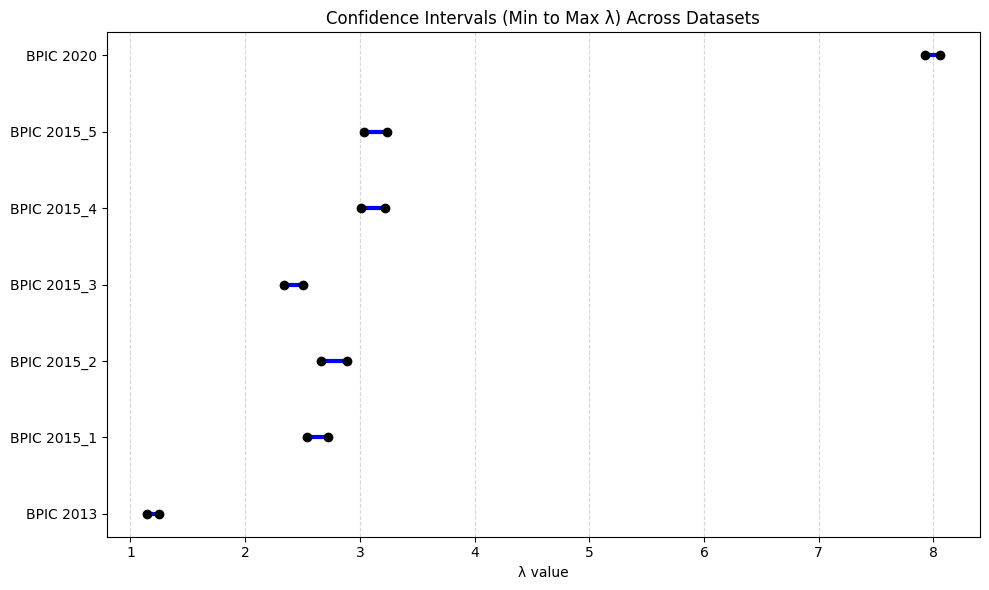

In [70]:
datasets = ["BPIC 2013", "BPIC 2015_1", "BPIC 2015_2", "BPIC 2015_3", "BPIC 2015_4", "BPIC 2015_5", "BPIC 2020"]
min_lambda = [1.14, 2.54, 2.66, 2.34, 3.01, 3.04, 7.93]
max_lambda = [1.25, 2.72, 2.89, 2.50, 3.22, 3.24, 8.06]

import matplotlib.pyplot as plt
import numpy as np

# Convert to numeric indexes for plotting
# Convert to y-positions
y_pos = range(len(datasets))

# Plot
plt.figure(figsize=(10, 6))
for i, (y, lo, hi) in enumerate(zip(y_pos, min_lambda, max_lambda)):
    plt.hlines(y, lo, hi, color="blue", linewidth=3)  # Draw horizontal line
    plt.plot([lo, hi], [y, y], 'o', color='black')    # Endpoints

# Formatting
plt.yticks(y_pos, datasets)
plt.xlabel("λ value")
plt.title("Confidence Intervals (Min to Max λ) Across Datasets")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


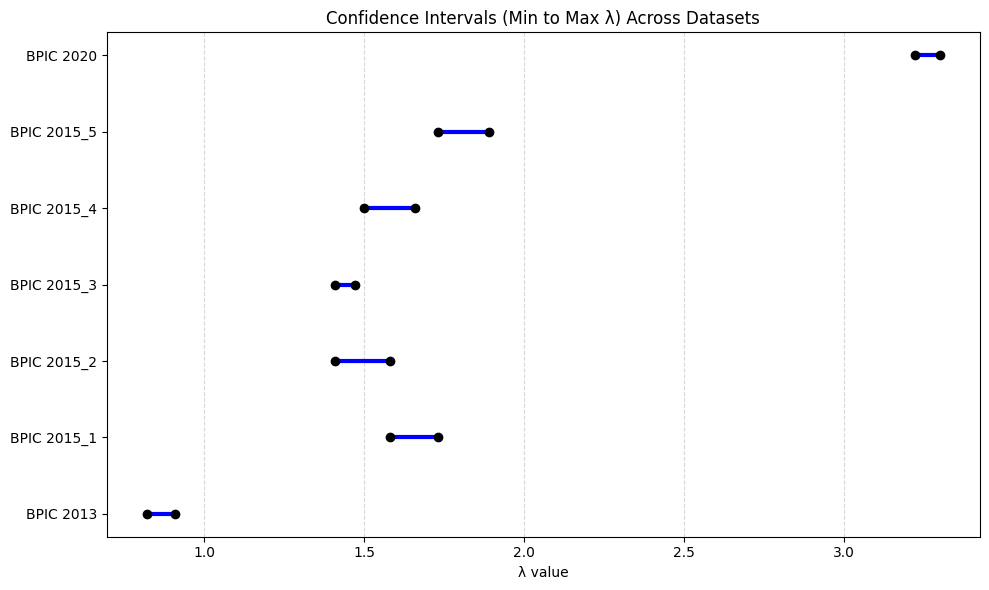

In [71]:
datasets = ["BPIC 2013", "BPIC 2015_1", "BPIC 2015_2", "BPIC 2015_3", "BPIC 2015_4", "BPIC 2015_5", "BPIC 2020"]
min_lambda = [0.82, 1.58, 1.41, 1.47, 1.50, 1.73, 3.22]
max_lambda = [0.91, 1.73, 1.58, 1.41, 1.66, 1.89, 3.30]

import matplotlib.pyplot as plt
import numpy as np

# Convert to numeric indexes for plotting
# Convert to y-positions
y_pos = range(len(datasets))

# Plot
plt.figure(figsize=(10, 6))
for i, (y, lo, hi) in enumerate(zip(y_pos, min_lambda, max_lambda)):
    plt.hlines(y, lo, hi, color="blue", linewidth=3)  # Draw horizontal line
    plt.plot([lo, hi], [y, y], 'o', color='black')    # Endpoints

# Formatting
plt.yticks(y_pos, datasets)
plt.xlabel("λ value")
plt.title("Confidence Intervals (Min to Max λ) Across Datasets")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [87]:
# involve machine learning datasets
df_2011_ML = pd.read_csv('/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/bpic_2011_machine_learning.csv')
df_2012_ML = pd.read_csv('/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/bpic_2012_machine_learning.csv')
df_2013_ML = pd.read_csv('/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/bpic_2013_machine_learning.csv')
df_2014_ML = pd.read_csv('/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/bpic_2014_machine_learning.csv')
df_2015_1_ML = pd.read_csv('/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/bpic_2015_1_machine_learning.csv')
df_2015_2_ML = pd.read_csv('/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/bpic_2015_2_machine_learning.csv')
df_2015_3_ML = pd.read_csv('/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/bpic_2015_3_machine_learning.csv')
df_2015_4_ML = pd.read_csv('/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/bpic_2015_4_machine_learning.csv')
df_2015_5_ML = pd.read_csv('/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/bpic_2015_5_machine_learning.csv')
df_2020_ML = pd.read_csv('/Users/qingtan/Desktop/resource_identify_step_two_results_method_2/bpic_2020_machine_learning.csv')


# involve randomly distributed
df_2011_RD = pd.read_csv('/Users/qingtan/Desktop/resource_assign_logs/bpic_2011_randomly_distributed_assigned.csv')
df_2012_RD = pd.read_csv('/Users/qingtan/Desktop/resource_assign_logs/bpic_2012_randomly_distributed_assigned.csv')
df_2013_RD = pd.read_csv('/Users/qingtan/Desktop/resource_assign_logs/bpic_2013_randomly_distributed_assigned.csv')
df_2014_RD = pd.read_csv('/Users/qingtan/Desktop/resource_assign_logs/bpic_2014_randomly_distributed_assigned.csv')
df_2015_1_RD = pd.read_csv('/Users/qingtan/Desktop/resource_assign_logs/bpic_2015_1_randomly_distributed_assigned.csv')
df_2015_2_RD = pd.read_csv('/Users/qingtan/Desktop/resource_assign_logs/bpic_2015_2_randomly_distributed_assigned.csv')
df_2015_3_RD = pd.read_csv('/Users/qingtan/Desktop/resource_assign_logs/bpic_2015_3_randomly_distributed_assigned.csv')
df_2015_4_RD = pd.read_csv('/Users/qingtan/Desktop/resource_assign_logs/bpic_2015_4_randomly_distributed_assigned.csv')
df_2015_5_RD = pd.read_csv('/Users/qingtan/Desktop/resource_assign_logs/bpic_2015_5_randomly_distributed_assigned.csv')
df_2020_RD = pd.read_csv('/Users/qingtan/Desktop/resource_assign_logs/bpic_2020_randomly_distributed_assigned.csv')

bpic_2011


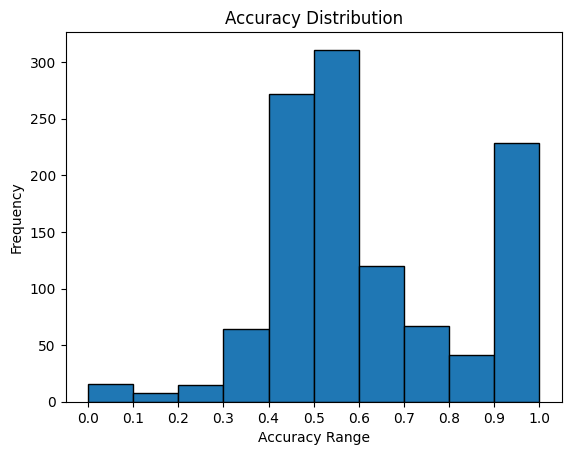

0.6225293854985644

bpic_2012


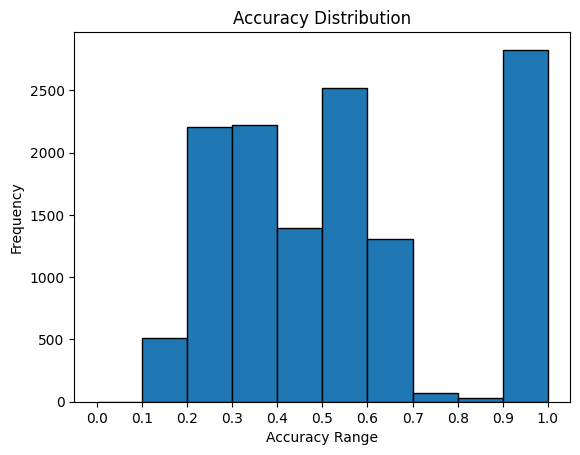

0.5412611088922017

bpic_2013


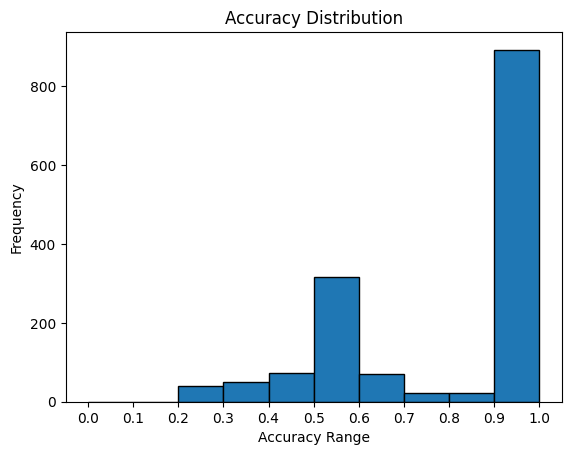

0.806167346619252

bpic_2015_1


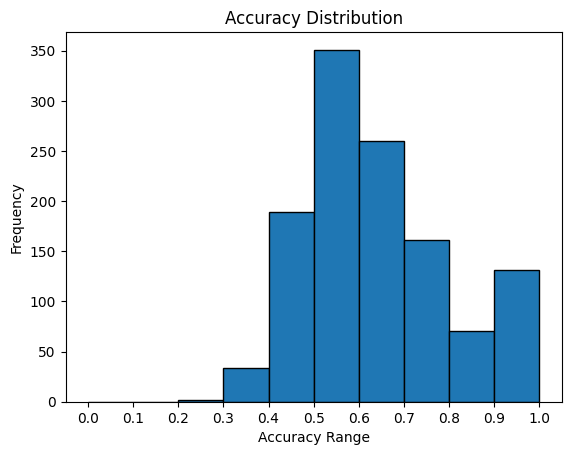

0.6427164890650804

bpic_2015_2


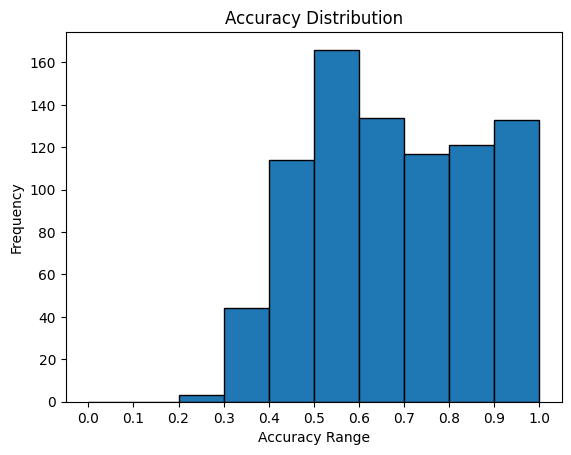

0.6799271899324638

bpic_2015_3


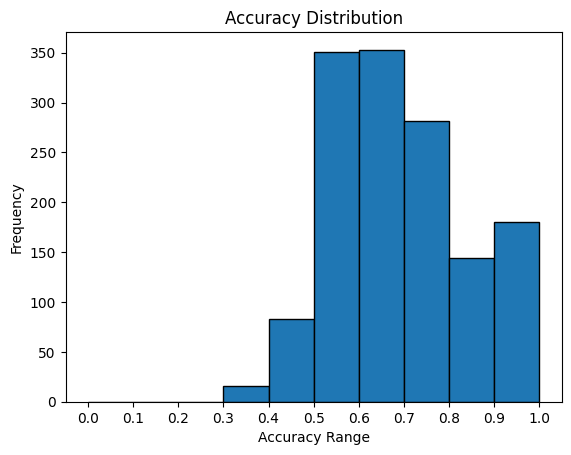

0.6927307118216076

bpic_2015_4


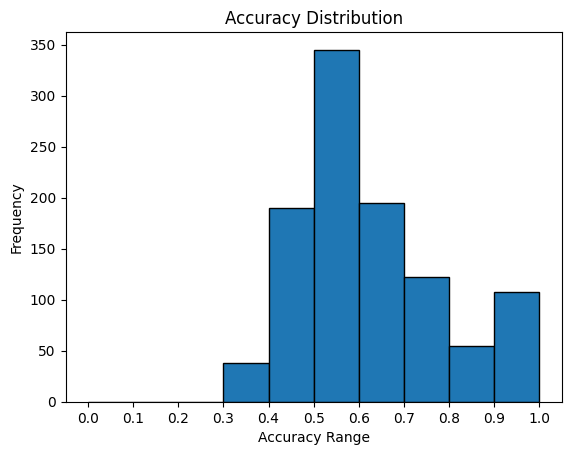

0.6238071188769918

bpic_2015_5


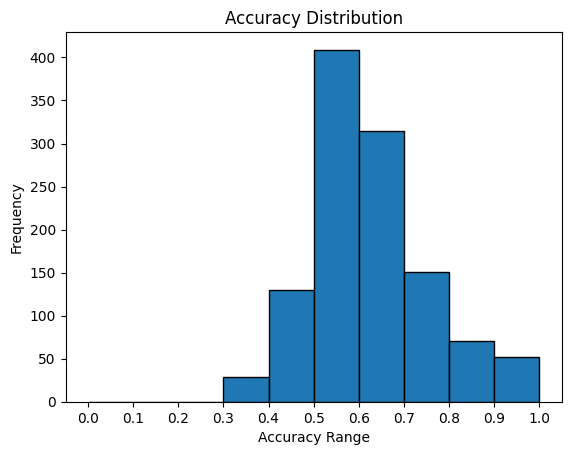

0.6235674488227892

bpic_2020


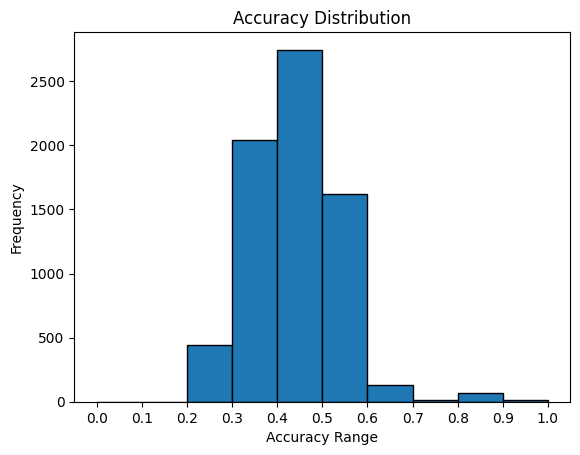

0.4228470271250528



In [93]:
# a new kinds of evaluation (start by the machine learning approach)
from itertools import combinations, permutations
from collections import defaultdict
import matplotlib.pyplot as plt

def get_theory_one_information_from_log_2(mas_log):
    # resource_action_dic = {R1:{T1:2,T2:4,...}, R2:[T2:1,T3:3,...]}
    # action_resource_dic = {T1:[R1:1,R2:3,...], T2:[R3:4,R4:1,...]}
    # case_action = {C1:[T1,T2,T3, ...], C2:[T1,T2,...], ...}
    resource_action_dic = {}
    action_resource_dic = {}
    case_action_dic = {}
    case_name = -1
    # different resources set
    diff_resource_list = []
    # different actions set
    diff_task_list = []
    # collect all the resources
    whole_resource_l = []
    case_curr = -1
    case_list = []
    # in the BPIC15_1 xes, there are 1199 traces, each trace 43.55 tasks on average
    for trace_id in range(len(mas_log)):
        # resource_action_list = [(resource, action), (), ...]
        resource_action_list = []
        case_name = 'Case_' + str(trace_id)
        current_trace = mas_log[trace_id]
        case_action_l = []
        case_curr += 1
        for task_id in range(len(mas_log[trace_id])):
            case_list.append(case_curr)
            current_resource = current_trace[task_id]['agent_id']
            whole_resource_l.append(current_resource)
            # current_task_name = current_trace[task_id]['activity_type']
            current_task_name = current_trace[task_id]['concept:name']
            case_action_l.append(current_task_name)
            if current_resource not in diff_resource_list:
                diff_resource_list.append(current_resource)
            if current_task_name not in diff_task_list:
                diff_task_list.append(current_task_name)
            # resource_action_list.append((current_resource, current_task_name))
        # resource_action_dic[trace_name] = resource_action_list
            if current_resource not in resource_action_dic.keys():
                act_dic = {}
                act_dic[current_task_name] = 1
                resource_action_dic[current_resource] = act_dic
            else:
                if current_task_name not in resource_action_dic[current_resource].keys():
                    resource_action_dic[current_resource][current_task_name] = 1
                else:
                    resource_action_dic[current_resource][current_task_name] += 1

            if current_task_name not in action_resource_dic.keys():
                res_dic = {}
                res_dic[current_resource] = 1
                action_resource_dic[current_task_name] = res_dic
            else:
                if current_resource not in action_resource_dic[current_task_name].keys():
                    action_resource_dic[current_task_name][current_resource] = 1
                else:
                    action_resource_dic[current_task_name][current_resource] += 1

        case_action_dic[case_name] = case_action_l

    return resource_action_dic, action_resource_dic, case_action_dic, diff_resource_list, diff_task_list, whole_resource_l, case_list


def compute_case_accuracies(case_attributes, assigned_resources, ground_truth_resources):
    # Group events by case ID
    cases = defaultdict(list)
    for case_id, a, gt in zip(case_attributes, assigned_resources, ground_truth_resources):
        cases[case_id].append((a, gt))
    
    case_accuracies = {}
    accuracy_sum = 0
    
    for case_id, events in cases.items():
        # Build frequency dictionary and collect unique resources
        freq = defaultdict(lambda: defaultdict(int))
        unique_assigned = set()
        unique_gt = set()
        for a, gt in events:
            freq[a][gt] += 1
            unique_assigned.add(a)
            unique_gt.add(gt)
        unique_assigned = list(unique_assigned)
        unique_gt = list(unique_gt)
        n_assigned = len(unique_assigned)
        n_gt = len(unique_gt)
        
        max_total = 0
        total_events = len(events)
        
        if total_events == 0:
            case_accuracies[case_id] = 0.0
            continue
        
        if n_assigned == 0 or n_gt == 0:
            case_accuracies[case_id] = 0.0
            continue
        
        if n_assigned > n_gt:
            # Check all possible subsets of assigned resources of size n_gt
            iter_num = 0
            for subset in combinations(unique_assigned, n_gt):
                iter_num += 1
                # Check all possible permutations of ground truths
                for perm in permutations(unique_gt):
                    current_sum = 0
                    for a, gt in zip(subset, perm):
                        current_sum += freq[a].get(gt, 0)
                    if current_sum > max_total:
                        max_total = current_sum
                if iter_num > 500:
                    break
        else:
            # Check all possible injective mappings from assigned to ground truths
            iter_num_1 = 0
            for perm in permutations(unique_gt, n_assigned):
                iter_num_1 += 1
                current_sum = 0
                for a, gt in zip(unique_assigned, perm):
                    current_sum += freq[a].get(gt, 0)
                if current_sum > max_total:
                    max_total = current_sum
                if iter_num_1 > 500:
                    break
        
        accuracy = max_total / total_events
        accuracy_sum += accuracy
        case_accuracies[case_id] = accuracy
    
    return case_accuracies, accuracy_sum / len(case_accuracies)


def get_ground_truth_res_l(df_dic, dataset_name):
    ground_truth_res_l = ''
    for df_name, df in df_dic.items():
        if df_name == dataset_name:
            df1 = df[0].rename(columns={
                'case_id': 'case:concept:name',     # Replace with actual case column name
                'activity_type': 'concept:name',  # Replace with actual activity column name
                'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
            })
            unclustered_log = log_converter.apply(df1)

            resource_action_dic, action_resource_dic, case_action_dic, diff_resource_list, diff_task_list, whole_resource_l, case_list= get_theory_one_information_from_log_2(unclustered_log)
            ground_truth_res_l = whole_resource_l
    
    return ground_truth_res_l, case_list


df_name_l = ['bpic_2011','bpic_2012','bpic_2013','bpic_2015_1','bpic_2015_2','bpic_2015_3','bpic_2015_4','bpic_2015_5','bpic_2020']
df_dic_with_time = {'bpic_2011': (df_2011, format_1), 'bpic_2012':(df_2012, format_2), 'bpic_2013':(df_2013, format_1), 'bpic_2014':(df_2014, format_2), 'bpic_2015_1':(df_2015_1, format_3), 
          'bpic_2015_2':(df_2015_2, format_2), 'bpic_2015_3':(df_2015_3, format_2), 'bpic_2015_4':(df_2015_4, format_2), 'bpic_2015_5':(df_2015_5, format_2), 'bpic_2020':(df_2020, format_3)}

df_dic_with_time_ML = {'bpic_2011': (df_2011_ML, format_1), 'bpic_2012':(df_2012_ML, format_2), 'bpic_2013':(df_2013_ML, format_1), 'bpic_2014':(df_2014_ML, format_2), 'bpic_2015_1':(df_2015_1_ML, format_3), 
          'bpic_2015_2':(df_2015_2_ML, format_2), 'bpic_2015_3':(df_2015_3_ML, format_2), 'bpic_2015_4':(df_2015_4_ML, format_2), 'bpic_2015_5':(df_2015_5_ML, format_2), 'bpic_2020':(df_2020_ML, format_3)}

df_dic_with_time_RD = {'bpic_2011': (df_2011_RD, format_1), 'bpic_2012':(df_2012_RD, format_2), 'bpic_2013':(df_2013_RD, format_1), 'bpic_2014':(df_2014_RD, format_2), 'bpic_2015_1':(df_2015_1_RD, format_3), 
          'bpic_2015_2':(df_2015_2_RD, format_2), 'bpic_2015_3':(df_2015_3_RD, format_2), 'bpic_2015_4':(df_2015_4_RD, format_2), 'bpic_2015_5':(df_2015_5_RD, format_2), 'bpic_2020':(df_2020_RD, format_3)}

for i in range(len(df_name_l)):
    df_name = df_name_l[i]
    print(df_name)
    data = df_dic_with_time[df_name][0]
    # case_ids, event_groups, target_event_l, target_case_l, case_event_normalize = assign_res_for_a_single_log(df_name, act_perc_dic, case_perc_dic)
    # best_assignments, best_cost = simulated_annealing_with_groups(case_ids, target_event_l, target_case_l, num_resources=20, event_groups=event_groups, case_event_normalize=case_event_normalize, initial_temp=10000, cooling_rate=0.99, max_iter=1000000)
    ground_truth_res_l, case_ids = get_ground_truth_res_l(df_dic_with_time, df_name)
    ML_best_assignments, case_l = get_ground_truth_res_l(df_dic_with_time_ML, df_name)
    accuracies, aver_acc = compute_case_accuracies(case_ids, ML_best_assignments, ground_truth_res_l)
    accuracy_l = []
    for case_id, accuracy in accuracies.items():
        accuracy_l.append(accuracy)

    # Define bin edges
    bins = np.arange(0, max(accuracy_l) + 0.1, 0.1)

    # Compute histogram
    hist, bin_edges = np.histogram(accuracy_l, bins=bins)

    # Plot bar chart
    plt.bar(bin_edges[:-1], hist, width=0.1, align='edge', edgecolor='black')
    plt.xlabel('Accuracy Range')
    plt.ylabel('Frequency')
    plt.title('Accuracy Distribution')
    plt.xticks(bin_edges)

    plt.show()
    print(aver_acc)
    print()

bpic_2015_1


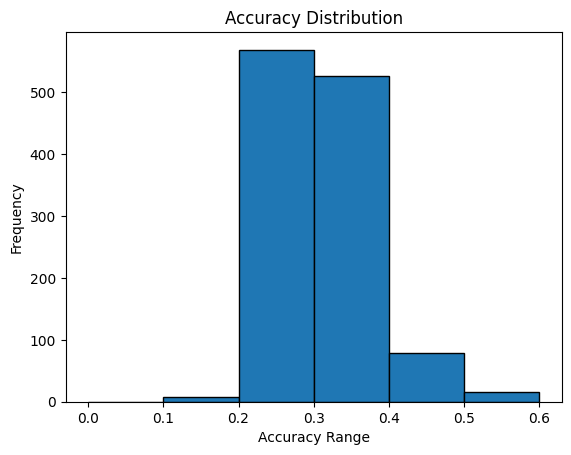

0.31175579750314947

bpic_2015_2


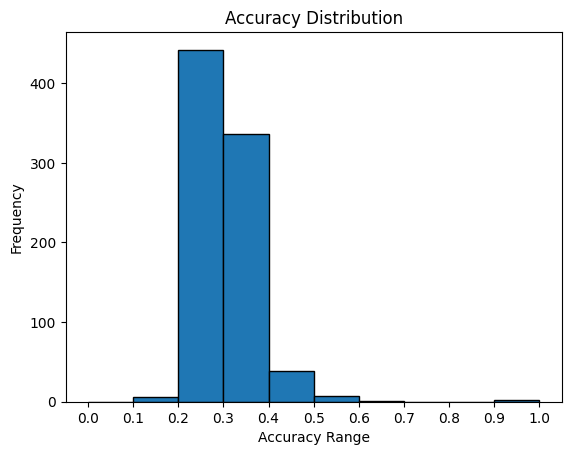

0.3072335984094491

bpic_2015_3


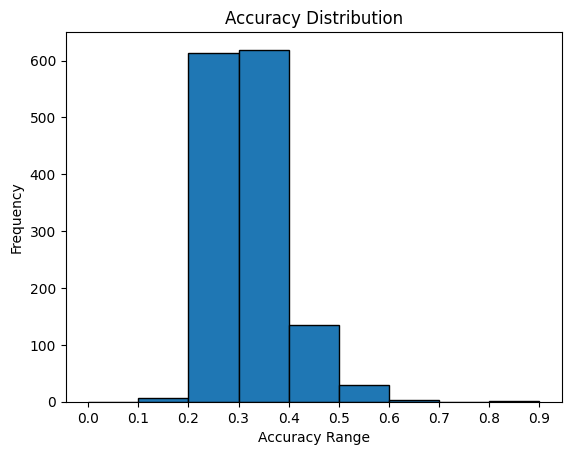

0.32130917946133997

bpic_2015_4


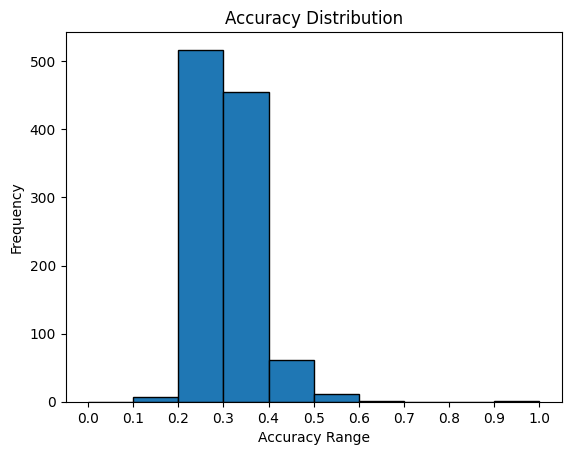

0.30897532689818363

bpic_2015_5


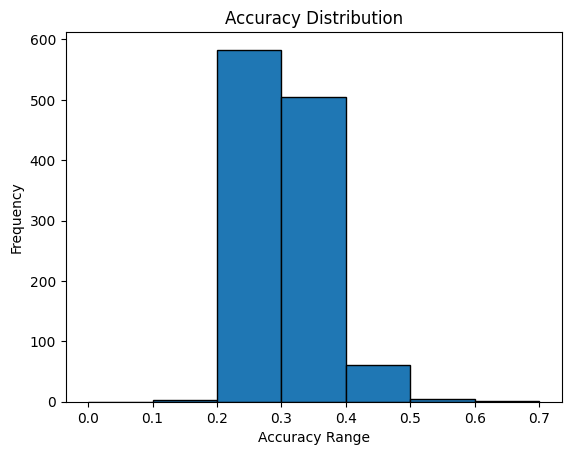

0.30786434646146166

bpic_2020


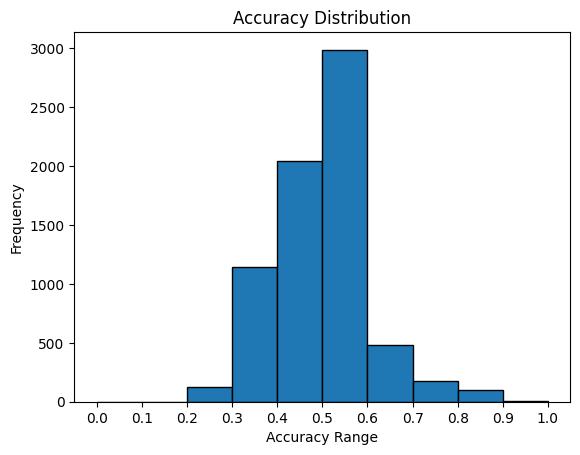

0.4869161262359349



In [94]:
df_name_l = ['bpic_2015_1','bpic_2015_2','bpic_2015_3','bpic_2015_4','bpic_2015_5','bpic_2020']

for i in range(len(df_name_l)):
    df_name = df_name_l[i]
    print(df_name)
    data = df_dic_with_time[df_name][0]
    # case_ids, event_groups, target_event_l, target_case_l, case_event_normalize = assign_res_for_a_single_log(df_name, act_perc_dic, case_perc_dic)
    # best_assignments, best_cost = simulated_annealing_with_groups(case_ids, target_event_l, target_case_l, num_resources=20, event_groups=event_groups, case_event_normalize=case_event_normalize, initial_temp=10000, cooling_rate=0.99, max_iter=1000000)
    ground_truth_res_l, case_ids = get_ground_truth_res_l(df_dic_with_time, df_name)
    RD_best_assignments, case_l = get_ground_truth_res_l(df_dic_with_time_RD, df_name)
    accuracies, aver_acc = compute_case_accuracies(case_ids, RD_best_assignments, ground_truth_res_l)
    accuracy_l = []
    for case_id, accuracy in accuracies.items():
        accuracy_l.append(accuracy)

    # Define bin edges
    bins = np.arange(0, max(accuracy_l) + 0.1, 0.1)

    # Compute histogram
    hist, bin_edges = np.histogram(accuracy_l, bins=bins)

    # Plot bar chart
    plt.bar(bin_edges[:-1], hist, width=0.1, align='edge', edgecolor='black')
    plt.xlabel('Accuracy Range')
    plt.ylabel('Frequency')
    plt.title('Accuracy Distribution')
    plt.xticks(bin_edges)

    plt.show()
    print(aver_acc)
    print()

bpic_2013
1
2
3
4
0
1
2
3
4
5
6
1
1
2
3
4
5
6
2
1
2
3
1
2
3
4
5
4
1
2
3
4
5
6
5
1
2
3
4
5
6
6
1
2
3
4
5
6
7
8
9
10
7
1
2
8
1
2
3
9
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
10
1
2
3
11
1
2
3
4
12
1
2
3
13
1
14
1
2
3
15
1
2
3
4
5
16
1
2
3
17
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
18
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
19
1
2
3
4
5
6
20
1
2
3
4
5
21
1
2
3
4
5
6
22
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
1

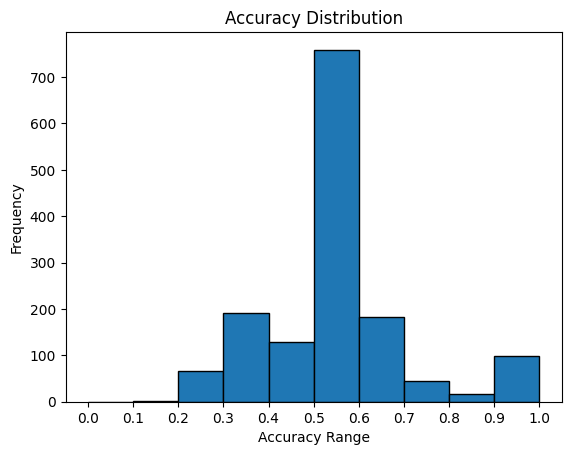

0.529530817457639



In [97]:
df_name_l = ['bpic_2013']


def compute_case_accuracies(case_attributes, assigned_resources, ground_truth_resources):
    # Group events by case ID
    cases = defaultdict(list)
    for case_id, a, gt in zip(case_attributes, assigned_resources, ground_truth_resources):
        cases[case_id].append((a, gt))
    
    case_accuracies = {}
    accuracy_sum = 0
    
    case_num = 0
    for case_id, events in cases.items():
        # Build frequency dictionary and collect unique resources
        freq = defaultdict(lambda: defaultdict(int))
        unique_assigned = set()
        unique_gt = set()
        for a, gt in events:
            freq[a][gt] += 1
            unique_assigned.add(a)
            unique_gt.add(gt)
        unique_assigned = list(unique_assigned)
        unique_gt = list(unique_gt)
        n_assigned = len(unique_assigned)
        n_gt = len(unique_gt)
        
        max_total = 0
        total_events = len(events)
        
        if total_events == 0:
            case_accuracies[case_id] = 0.0
            continue
        
        if n_assigned == 0 or n_gt == 0:
            case_accuracies[case_id] = 0.0
            continue
        
        if n_assigned > n_gt:
            # Check all possible subsets of assigned resources of size n_gt
            iter_num = 0
            for subset in combinations(unique_assigned, n_gt):
                iter_num += 1
                # Check all possible permutations of ground truths
                for perm in permutations(unique_gt):
                    current_sum = 0
                    for a, gt in zip(subset, perm):
                        current_sum += freq[a].get(gt, 0)
                    if current_sum > max_total:
                        max_total = current_sum
                if iter_num > 500:
                    break
                print(iter_num)
        else:
            # Check all possible injective mappings from assigned to ground truths
            iter_num_1 = 0
            for perm in permutations(unique_gt, n_assigned):
                iter_num_1 += 1
                current_sum = 0
                for a, gt in zip(unique_assigned, perm):
                    current_sum += freq[a].get(gt, 0)
                if current_sum > max_total:
                    max_total = current_sum
                if iter_num_1 > 500:
                    break
                print
        
        accuracy = max_total / total_events
        accuracy_sum += accuracy
        case_accuracies[case_id] = accuracy

        print(case_num)
        case_num += 1
    
    return case_accuracies, accuracy_sum / len(case_accuracies)


def get_ground_truth_res_l(df_dic, dataset_name):
    ground_truth_res_l = ''
    for df_name, df in df_dic.items():
        if df_name == dataset_name:
            df1 = df[0].rename(columns={
                'case_id': 'case:concept:name',     # Replace with actual case column name
                'activity_type': 'concept:name',  # Replace with actual activity column name
                'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
            })
            unclustered_log = log_converter.apply(df1)

            resource_action_dic, action_resource_dic, case_action_dic, diff_resource_list, diff_task_list, whole_resource_l, case_list= get_theory_one_information_from_log_2(unclustered_log)
            ground_truth_res_l = whole_resource_l
    
    return ground_truth_res_l, case_list


for i in range(len(df_name_l)):
    df_name = df_name_l[i]
    print(df_name)
    data = df_dic_with_time[df_name][0]
    # case_ids, event_groups, target_event_l, target_case_l, case_event_normalize = assign_res_for_a_single_log(df_name, act_perc_dic, case_perc_dic)
    # best_assignments, best_cost = simulated_annealing_with_groups(case_ids, target_event_l, target_case_l, num_resources=20, event_groups=event_groups, case_event_normalize=case_event_normalize, initial_temp=10000, cooling_rate=0.99, max_iter=1000000)
    ground_truth_res_l, case_ids = get_ground_truth_res_l(df_dic_with_time, df_name)
    RD_best_assignments, case_l = get_ground_truth_res_l(df_dic_with_time_RD, df_name)
    accuracies, aver_acc = compute_case_accuracies(case_ids, RD_best_assignments, ground_truth_res_l)
    accuracy_l = []
    for case_id, accuracy in accuracies.items():
        accuracy_l.append(accuracy)

    # Define bin edges
    bins = np.arange(0, max(accuracy_l) + 0.1, 0.1)

    # Compute histogram
    hist, bin_edges = np.histogram(accuracy_l, bins=bins)

    # Plot bar chart
    plt.bar(bin_edges[:-1], hist, width=0.1, align='edge', edgecolor='black')
    plt.xlabel('Accuracy Range')
    plt.ylabel('Frequency')
    plt.title('Accuracy Distribution')
    plt.xticks(bin_edges)

    plt.show()
    print(aver_acc)
    print()

bpic_2014
1
2
3
4
5
6
0
1
2
3
4
5
6
7
8
9
10
11
12
1
1
2
3
4
5
6
7
8
9
10
11
12
2
1
2
3
1
2
4
1
2
5
1
2
6
1
2
7
1
2
8
1
2
9
1
2
3
4
5
6
10
1
2
3
4
5
6
11
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
12
1
13
1
2
3
4
5
14
1
2
3
15
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
16
1
17
1
2
3
4
5
6
18
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
11

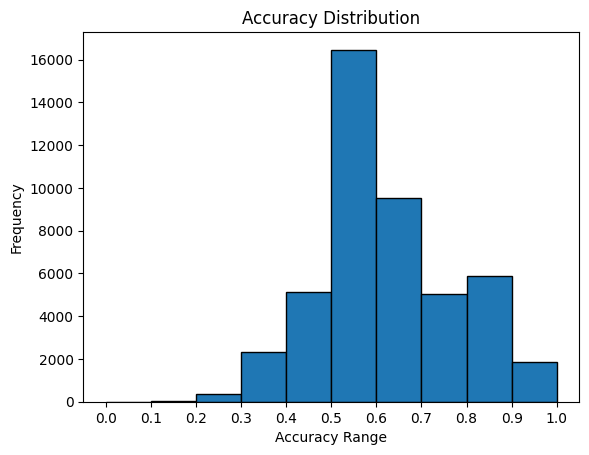

0.6196639354246208



In [98]:
df_name_l = ['bpic_2014']

for i in range(len(df_name_l)):
    df_name = df_name_l[i]
    print(df_name)
    data = df_dic_with_time[df_name][0]
    # case_ids, event_groups, target_event_l, target_case_l, case_event_normalize = assign_res_for_a_single_log(df_name, act_perc_dic, case_perc_dic)
    # best_assignments, best_cost = simulated_annealing_with_groups(case_ids, target_event_l, target_case_l, num_resources=20, event_groups=event_groups, case_event_normalize=case_event_normalize, initial_temp=10000, cooling_rate=0.99, max_iter=1000000)
    ground_truth_res_l, case_ids = get_ground_truth_res_l(df_dic_with_time, df_name)
    RD_best_assignments, case_l = get_ground_truth_res_l(df_dic_with_time_ML, df_name)
    accuracies, aver_acc = compute_case_accuracies(case_ids, RD_best_assignments, ground_truth_res_l)
    accuracy_l = []
    for case_id, accuracy in accuracies.items():
        accuracy_l.append(accuracy)

    # Define bin edges
    bins = np.arange(0, max(accuracy_l) + 0.1, 0.1)

    # Compute histogram
    hist, bin_edges = np.histogram(accuracy_l, bins=bins)

    # Plot bar chart
    plt.bar(bin_edges[:-1], hist, width=0.1, align='edge', edgecolor='black')
    plt.xlabel('Accuracy Range')
    plt.ylabel('Frequency')
    plt.title('Accuracy Distribution')
    plt.xticks(bin_edges)

    plt.show()
    print(aver_acc)
    print()

In [108]:
df_name_l = ['bpic_2012', 'bpic_2014']

for i in range(len(df_name_l)):
    df_name = df_name_l[i]
    print(df_name)
    data = df_dic_with_time[df_name][0]
    # case_ids, event_groups, target_event_l, target_case_l, case_event_normalize = assign_res_for_a_single_log(df_name, act_perc_dic, case_perc_dic)
    # best_assignments, best_cost = simulated_annealing_with_groups(case_ids, target_event_l, target_case_l, num_resources=20, event_groups=event_groups, case_event_normalize=case_event_normalize, initial_temp=10000, cooling_rate=0.99, max_iter=1000000)
    ground_truth_res_l, case_ids = get_ground_truth_res_l(df_dic_with_time, df_name)
    RD_best_assignments, case_l = get_ground_truth_res_l(df_dic_with_time_RD, df_name)
    accuracies, aver_acc = compute_case_accuracies(case_ids, RD_best_assignments, ground_truth_res_l)
    accuracy_l = []
    for case_id, accuracy in accuracies.items():
        accuracy_l.append(accuracy)

    # Define bin edges
    bins = np.arange(0, max(accuracy_l) + 0.1, 0.1)

    # Compute histogram
    hist, bin_edges = np.histogram(accuracy_l, bins=bins)

    # Plot bar chart
    plt.bar(bin_edges[:-1], hist, width=0.1, align='edge', edgecolor='black')
    plt.xlabel('Accuracy Range')
    plt.ylabel('Frequency')
    plt.title('Accuracy Distribution')
    plt.xticks(bin_edges)

    plt.show()
    print(aver_acc)
    print()

bpic_2012
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
1
1
2
3
4
5
6

KeyboardInterrupt: 

bpic_2013
1
0
1
2
1
1
2
2
1
2
3
1
4
1
2
5
1
2
6
1
2
7
1
2
8
1
9
1
2
3
4
5
6
10
1
11
1
12
1
13
1
14
1
15
1
2
3
4
5
6
7
8
9
10
11
12
16
1
17
1
2
3
18
1
2
3
4
5
6
7
8
9
10
11
12
19
1
2
20
1
2
3
4
21
1
22
1
2
3
4
5
6
7
23
1
24
1
25
1
26
1
27
1
28
1
29
1
30
1
31
1
2
32
1
33
1
34
1
2
35
1
36
1
37
1
38
1
39
1
40
1
2
41
1
2
42
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
43
1
2
44
1
2
45
1
2
3
4
5
6
46
1
2
3
47
1
2
3
4
5
6
48
1
49
1
2
50
1
51
1
2
52
1
53
1
2
3
54
1
2
3
4
5
6
7
8
9
10
11
12
55
1
56
1
57
1
58
1
59
1
2
3
60
1
2
3
61
1
62
1
2
63
1
2
3
4
64
1
2
3
65
1
66
1
2
3
67
1
68
1
2
3
4
5
6
69
1
2
3
70
1
2
3
4
5
71
1
2
3
72
1
2
3
4
73
1
2
74
1
2
3
75
1
2
3
4
5
6
76
1
2
3
4
5
6
77
1
2
3
4
5
6
78
1
2
3
4
5
6
79
1
2
3
80
1
2
81
1
2
3
4
5
6
7
8
9
10
11
12
82
1
2
3
4
5
6
83
1
84
1
2
3
85
1
2
86
1
2
3
4
5
6
87
1
2
3
4
5
6
88
1
2
3
89
1
2
3
4
5
6
7
8
9
10
11
12
90
1
2
3
4
5
6
91
1
2
3
4
5
6
92
1
2
3
4
5
6
93
1
2
3
94
1
2
95
1
2
3
96
1
2
3
4
5
97
1
2
3
4
5
6
98
1
2
3
99
1
2
3
4
5
100
1
2
3
101


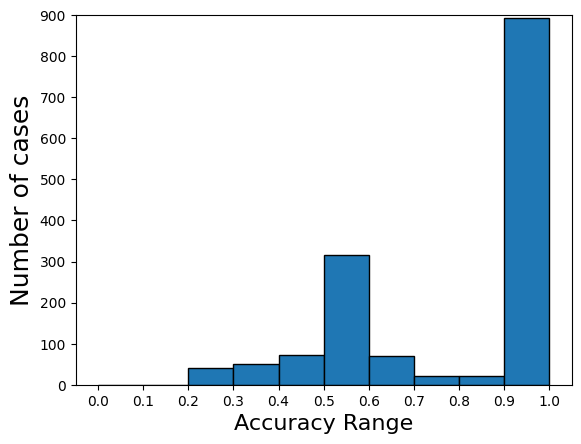

0.806167346619252



In [105]:
df_name_l = ['bpic_2013']

for i in range(len(df_name_l)):
    df_name = df_name_l[i]
    print(df_name)
    data = df_dic_with_time[df_name][0]
    # case_ids, event_groups, target_event_l, target_case_l, case_event_normalize = assign_res_for_a_single_log(df_name, act_perc_dic, case_perc_dic)
    # best_assignments, best_cost = simulated_annealing_with_groups(case_ids, target_event_l, target_case_l, num_resources=20, event_groups=event_groups, case_event_normalize=case_event_normalize, initial_temp=10000, cooling_rate=0.99, max_iter=1000000)
    ground_truth_res_l, case_ids = get_ground_truth_res_l(df_dic_with_time, df_name)
    RD_best_assignments, case_l = get_ground_truth_res_l(df_dic_with_time_ML, df_name)
    accuracies, aver_acc = compute_case_accuracies(case_ids, RD_best_assignments, ground_truth_res_l)
    accuracy_l = []
    for case_id, accuracy in accuracies.items():
        accuracy_l.append(accuracy)

    # Define bin edges
    bins = np.arange(0, max(accuracy_l) + 0.1, 0.1)

    # Compute histogram
    hist, bin_edges = np.histogram(accuracy_l, bins=bins)

    # Plot bar chart
    plt.bar(bin_edges[:-1], hist, width=0.1, align='edge', edgecolor='black')
    plt.xlabel('Accuracy Range', fontsize=16)
    plt.ylabel('Number of cases', fontsize=18)
    plt.ylim(0, 900)
    plt.yticks(np.arange(0, 901, 100))
    # plt.title('Accuracy Distribution')
    plt.xticks(bin_edges)
    plt.savefig('/Users/qingtan/Desktop/evaluation_m3_ML.pdf', format='pdf')
    plt.show()
    print(aver_acc)
    print()

bpic_2013
1
2
3
4
0
1
2
3
4
5
6
1
1
2
3
4
5
6
2
1
2
3
1
2
3
4
5
4
1
2
3
4
5
6
5
1
2
3
4
5
6
6
1
2
3
4
5
6
7
8
9
10
7
1
2
8
1
2
3
9
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
10
1
2
3
11
1
2
3
4
12
1
2
3
13
1
14
1
2
3
15
1
2
3
4
5
16
1
2
3
17
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
18
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
19
1
2
3
4
5
6
20
1
2
3
4
5
21
1
2
3
4
5
6
22
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
1

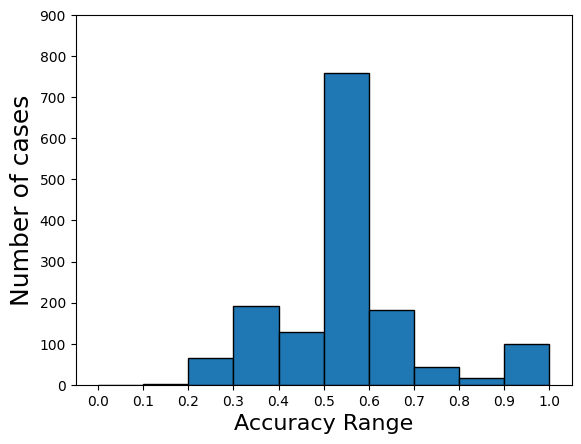

0.529530817457639



In [106]:
df_name_l = ['bpic_2013']

for i in range(len(df_name_l)):
    df_name = df_name_l[i]
    print(df_name)
    data = df_dic_with_time[df_name][0]
    # case_ids, event_groups, target_event_l, target_case_l, case_event_normalize = assign_res_for_a_single_log(df_name, act_perc_dic, case_perc_dic)
    # best_assignments, best_cost = simulated_annealing_with_groups(case_ids, target_event_l, target_case_l, num_resources=20, event_groups=event_groups, case_event_normalize=case_event_normalize, initial_temp=10000, cooling_rate=0.99, max_iter=1000000)
    ground_truth_res_l, case_ids = get_ground_truth_res_l(df_dic_with_time, df_name)
    RD_best_assignments, case_l = get_ground_truth_res_l(df_dic_with_time_RD, df_name)
    accuracies, aver_acc = compute_case_accuracies(case_ids, RD_best_assignments, ground_truth_res_l)
    accuracy_l = []
    for case_id, accuracy in accuracies.items():
        accuracy_l.append(accuracy)

    # Define bin edges
    bins = np.arange(0, max(accuracy_l) + 0.1, 0.1)

    # Compute histogram
    hist, bin_edges = np.histogram(accuracy_l, bins=bins)

    # Plot bar chart
    plt.bar(bin_edges[:-1], hist, width=0.1, align='edge', edgecolor='black')
    plt.xlabel('Accuracy Range', fontsize=16)
    plt.ylabel('Number of cases', fontsize=18)
    plt.ylim(0, 900)
    plt.yticks(np.arange(0, 901, 100))
    # plt.title('Accuracy Distribution')
    plt.xticks(bin_edges)
    plt.savefig('/Users/qingtan/Desktop/evaluation_m3_RD.pdf', format='pdf')
    plt.show()
    print(aver_acc)
    print()

bpic_2011


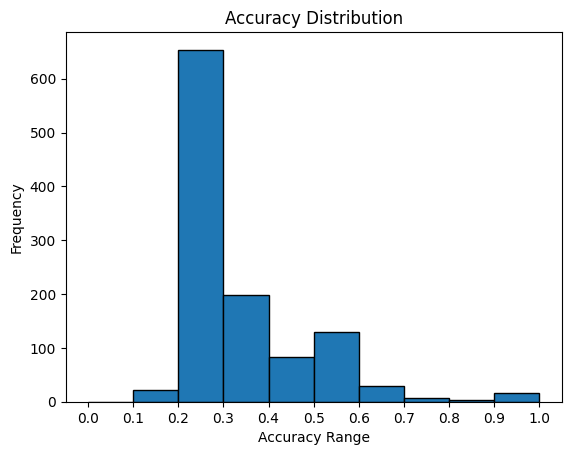

0.3338806461611561

bpic_2012


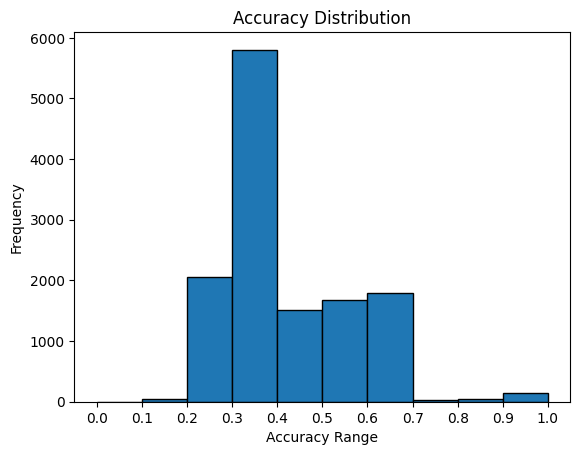

0.4146677107935003

bpic_2014


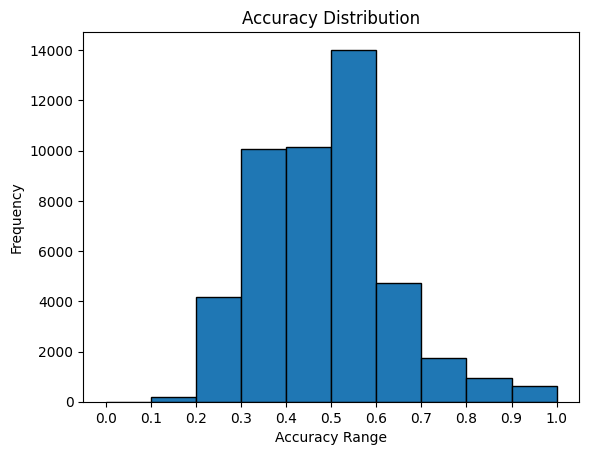

0.476581785261099



In [110]:
# a new kinds of evaluation (start by the machine learning approach)
from itertools import combinations, permutations
from collections import defaultdict
import matplotlib.pyplot as plt

def get_theory_one_information_from_log_2(mas_log):
    # resource_action_dic = {R1:{T1:2,T2:4,...}, R2:[T2:1,T3:3,...]}
    # action_resource_dic = {T1:[R1:1,R2:3,...], T2:[R3:4,R4:1,...]}
    # case_action = {C1:[T1,T2,T3, ...], C2:[T1,T2,...], ...}
    resource_action_dic = {}
    action_resource_dic = {}
    case_action_dic = {}
    case_name = -1
    # different resources set
    diff_resource_list = []
    # different actions set
    diff_task_list = []
    # collect all the resources
    whole_resource_l = []
    case_curr = -1
    case_list = []
    # in the BPIC15_1 xes, there are 1199 traces, each trace 43.55 tasks on average
    for trace_id in range(len(mas_log)):
        # resource_action_list = [(resource, action), (), ...]
        resource_action_list = []
        case_name = 'Case_' + str(trace_id)
        current_trace = mas_log[trace_id]
        case_action_l = []
        case_curr += 1
        for task_id in range(len(mas_log[trace_id])):
            case_list.append(case_curr)
            current_resource = current_trace[task_id]['agent_id']
            whole_resource_l.append(current_resource)
            # current_task_name = current_trace[task_id]['activity_type']
            current_task_name = current_trace[task_id]['concept:name']
            case_action_l.append(current_task_name)
            if current_resource not in diff_resource_list:
                diff_resource_list.append(current_resource)
            if current_task_name not in diff_task_list:
                diff_task_list.append(current_task_name)
            # resource_action_list.append((current_resource, current_task_name))
        # resource_action_dic[trace_name] = resource_action_list
            if current_resource not in resource_action_dic.keys():
                act_dic = {}
                act_dic[current_task_name] = 1
                resource_action_dic[current_resource] = act_dic
            else:
                if current_task_name not in resource_action_dic[current_resource].keys():
                    resource_action_dic[current_resource][current_task_name] = 1
                else:
                    resource_action_dic[current_resource][current_task_name] += 1

            if current_task_name not in action_resource_dic.keys():
                res_dic = {}
                res_dic[current_resource] = 1
                action_resource_dic[current_task_name] = res_dic
            else:
                if current_resource not in action_resource_dic[current_task_name].keys():
                    action_resource_dic[current_task_name][current_resource] = 1
                else:
                    action_resource_dic[current_task_name][current_resource] += 1

        case_action_dic[case_name] = case_action_l

    return resource_action_dic, action_resource_dic, case_action_dic, diff_resource_list, diff_task_list, whole_resource_l, case_list


from collections import defaultdict

def compute_case_accuracies(case_attributes, assigned_resources, ground_truth_resources):
    cases = defaultdict(list)
    for case_id, a, gt in zip(case_attributes, assigned_resources, ground_truth_resources):
        cases[case_id].append((a, gt))
    
    case_accuracies = {}
    accuracy_sum = 0
    
    for case_id, events in cases.items():
        freq = defaultdict(lambda: defaultdict(int))
        total_events = len(events)
        
        if total_events == 0:
            case_accuracies[case_id] = 0.0
            continue

        for a, gt in events:
            freq[a][gt] += 1

        # Greedily find the best mapping
        remaining_assigned = set(freq.keys())
        remaining_gt = set(gt for sub in freq.values() for gt in sub)

        mapping = {}
        while remaining_assigned and remaining_gt:
            best_pair = None
            best_score = -1
            for a in remaining_assigned:
                for gt in remaining_gt:
                    score = freq[a].get(gt, 0)
                    if score > best_score:
                        best_score = score
                        best_pair = (a, gt)
            if best_pair is None:
                break  # no more matches
            a, gt = best_pair
            mapping[a] = gt
            remaining_assigned.remove(a)
            remaining_gt.remove(gt)

        # Count correct matches
        correct = 0
        for a, gt in events:
            if mapping.get(a) == gt:
                correct += 1

        accuracy = correct / total_events
        accuracy_sum += accuracy
        case_accuracies[case_id] = accuracy

    return case_accuracies, accuracy_sum / len(case_accuracies)



def get_ground_truth_res_l(df_dic, dataset_name):
    ground_truth_res_l = ''
    for df_name, df in df_dic.items():
        if df_name == dataset_name:
            df1 = df[0].rename(columns={
                'case_id': 'case:concept:name',     # Replace with actual case column name
                'activity_type': 'concept:name',  # Replace with actual activity column name
                'timestamp': 'time:timestamp'  # Replace with actual timestamp column name
            })
            unclustered_log = log_converter.apply(df1)

            resource_action_dic, action_resource_dic, case_action_dic, diff_resource_list, diff_task_list, whole_resource_l, case_list= get_theory_one_information_from_log_2(unclustered_log)
            ground_truth_res_l = whole_resource_l
    
    return ground_truth_res_l, case_list


df_name_l = ['bpic_2011','bpic_2012','bpic_2014']
df_dic_with_time = {'bpic_2011': (df_2011, format_1), 'bpic_2012':(df_2012, format_2), 'bpic_2013':(df_2013, format_1), 'bpic_2014':(df_2014, format_2), 'bpic_2015_1':(df_2015_1, format_3), 
          'bpic_2015_2':(df_2015_2, format_2), 'bpic_2015_3':(df_2015_3, format_2), 'bpic_2015_4':(df_2015_4, format_2), 'bpic_2015_5':(df_2015_5, format_2), 'bpic_2020':(df_2020, format_3)}

# df_dic_with_time_ML = {'bpic_2011': (df_2011_ML, format_1), 'bpic_2012':(df_2012_ML, format_2), 'bpic_2013':(df_2013_ML, format_1), 'bpic_2014':(df_2014_ML, format_2), 'bpic_2015_1':(df_2015_1_ML, format_3), 
#           'bpic_2015_2':(df_2015_2_ML, format_2), 'bpic_2015_3':(df_2015_3_ML, format_2), 'bpic_2015_4':(df_2015_4_ML, format_2), 'bpic_2015_5':(df_2015_5_ML, format_2), 'bpic_2020':(df_2020_ML, format_3)}

df_dic_with_time_RD = {'bpic_2011': (df_2011_RD, format_1), 'bpic_2012':(df_2012_RD, format_2), 'bpic_2014':(df_2014_RD, format_2)}

for i in range(len(df_name_l)):
    df_name = df_name_l[i]
    print(df_name)
    data = df_dic_with_time[df_name][0]
    # case_ids, event_groups, target_event_l, target_case_l, case_event_normalize = assign_res_for_a_single_log(df_name, act_perc_dic, case_perc_dic)
    # best_assignments, best_cost = simulated_annealing_with_groups(case_ids, target_event_l, target_case_l, num_resources=20, event_groups=event_groups, case_event_normalize=case_event_normalize, initial_temp=10000, cooling_rate=0.99, max_iter=1000000)
    ground_truth_res_l, case_ids = get_ground_truth_res_l(df_dic_with_time, df_name)
    RD_best_assignments, case_l = get_ground_truth_res_l(df_dic_with_time_RD, df_name)
    accuracies, aver_acc = compute_case_accuracies(case_ids, RD_best_assignments, ground_truth_res_l)
    accuracy_l = []
    for case_id, accuracy in accuracies.items():
        accuracy_l.append(accuracy)

    # Define bin edges
    bins = np.arange(0, max(accuracy_l) + 0.1, 0.1)

    # Compute histogram
    hist, bin_edges = np.histogram(accuracy_l, bins=bins)

    # Plot bar chart
    plt.bar(bin_edges[:-1], hist, width=0.1, align='edge', edgecolor='black')
    plt.xlabel('Accuracy Range')
    plt.ylabel('Frequency')
    plt.title('Accuracy Distribution')
    plt.xticks(bin_edges)

    plt.show()
    print(aver_acc)
    print()